In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import numpy as np

### Camera Calibration
In order to undistort images, we first need to calibrate the camera with several images (in this case chessboard images) and get the camera matrix and distortion coefficients needed to get the undistorted images

In [2]:
def calculate_calibration_objects(path_to_images, nx, ny):
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in imaga plane
    
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    images = glob.glob(path_to_images + '/calibration*.jpg')
    for idx, fname in enumerate(images):
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            mpimg.imsave('output_images/'+fname, img)    
    return objpoints, imgpoints


In [3]:
objpoints, imgpoints = calculate_calibration_objects('camera_cal', 9, 6)

Now we use `objpoints` and `imgpoints` to calculate the camera matrix and the distortion coefficients using openCV `cv2.calibrateCamera` function

In [4]:
def calibrate_camera(path_to_images, nx, ny):
    calibration_image = mpimg.imread(path_to_images+'/calibration1.jpg')
    img_size = (calibration_image.shape[1], calibration_image.shape[0])
    objpoints, imgpoints = calculate_calibration_objects(path_to_images, nx, ny)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    return mtx, dist

In [5]:
mtx, dist = calibrate_camera('camera_cal', 9, 6)
print(dist)

[[-0.24688507 -0.02373155 -0.00109831  0.00035107 -0.00259868]]


Now we can get the matrix and distortion coefficients to undistort an image using OpenCV `cv2.undistort` function and then we can plot a distorted image and its respective undistortion after calling the `undistort` function

In [6]:
def undistort(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

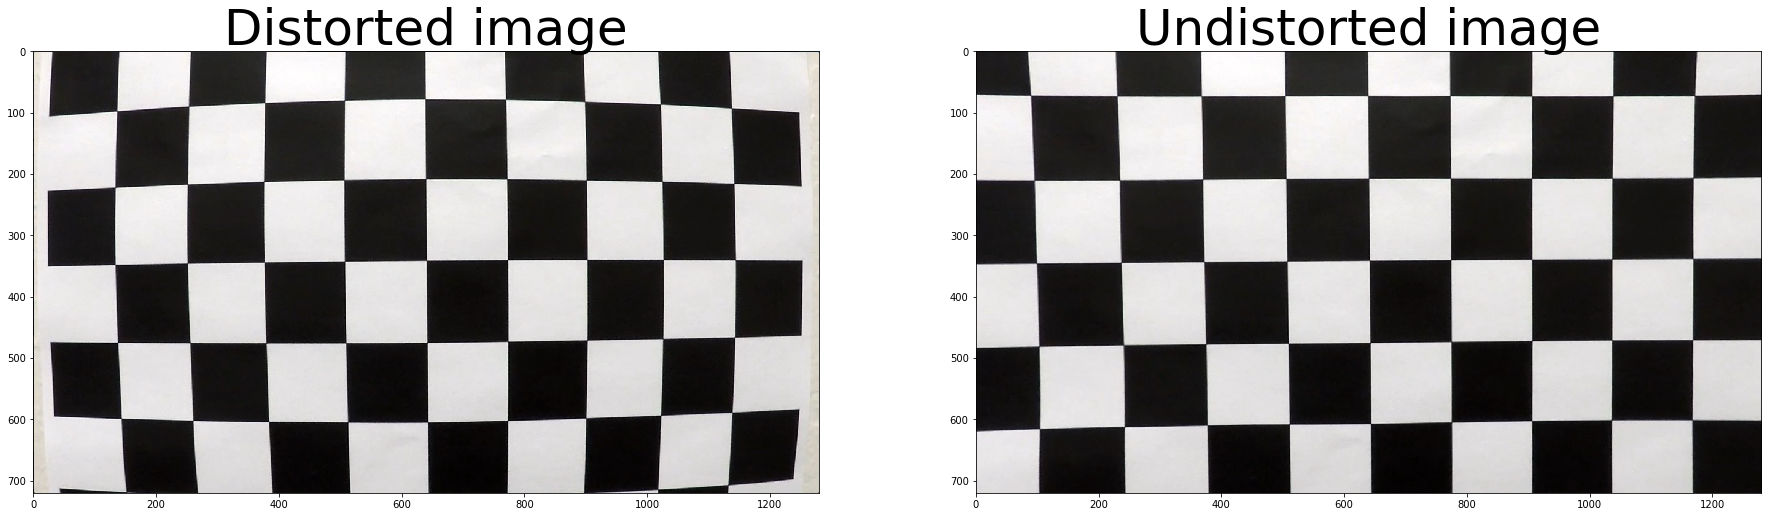

In [7]:
image = mpimg.imread('camera_cal/calibration1.jpg')
undistorted = undistort(image, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(image)
ax1.set_title('Distorted image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted image', fontsize=50)
plt.subplots_adjust(left=0., right=1., top=0.9, bottom=0.)
f.savefig('output_images/undistorted.png')

We can now get undistorted images from the example images like this

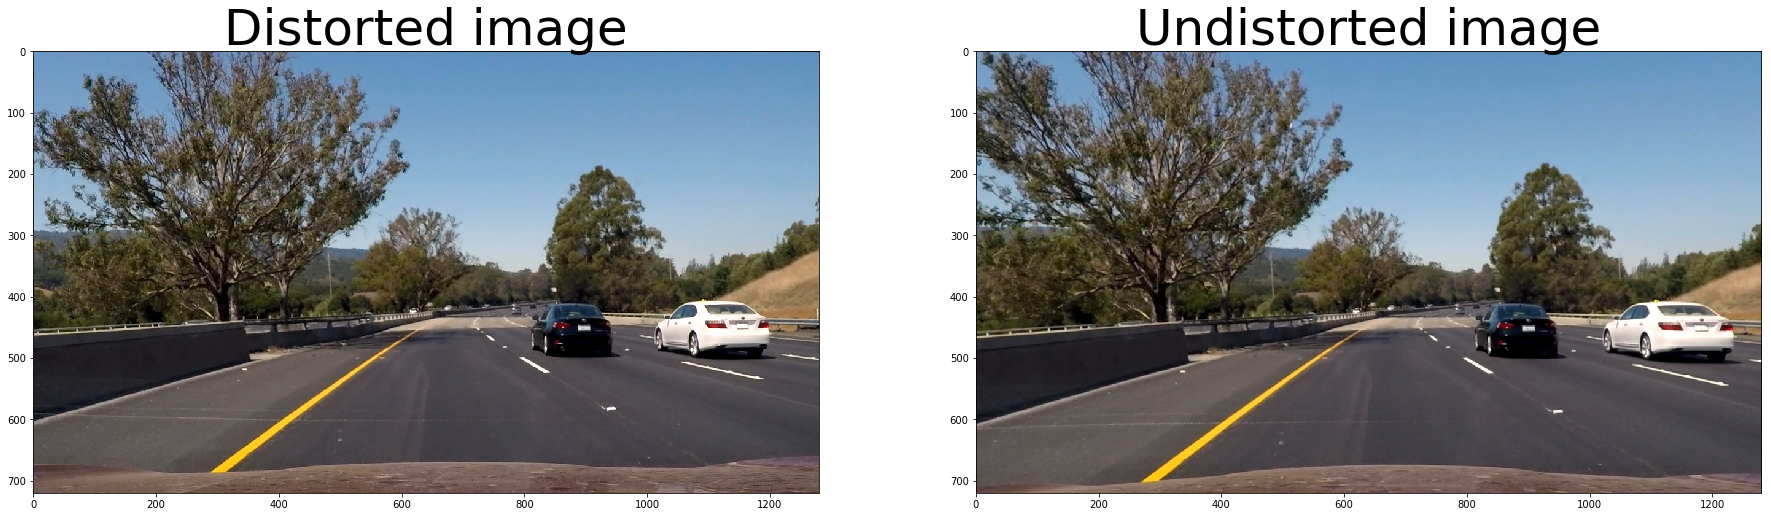

In [8]:
image = mpimg.imread('test_images/test6.jpg')
undistorted = undistort(image, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(image)
ax1.set_title('Distorted image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted image', fontsize=50)
plt.subplots_adjust(left=0., right=1., top=0.9, bottom=0.)
f.savefig('output_images/undistorted_test.png')

### Color and gradient threshold
In order to make a more robust detection of the lane lines (for example with light conditions and shadows), it is useful to use a different color space than RGB. In this case, we use HLS and apply a threshold over the S channel. We also apply a gradient threshold and combine both thresholded images to get a more robust transformation of the image

In [105]:
def color_threshold(image, s_thresh=(200, 255), v_thresh=(215, 255), l_thresh=(130, 255), b_thresh=(155, 200)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    luv = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    
    s = hls[:,:,2]
    v = hsv[:,:,2]
    l = luv[:,:,0]
    b = lab[:,:,2]
    
    s_binary = np.zeros_like(s)
    v_binary = np.zeros_like(v)
    l_binary = np.zeros_like(l)
    b_binary = np.zeros_like(b)
    
    s_binary[(s >= s_thresh[0]) & (s <= s_thresh[1])] = 1
    v_binary[(v >= v_thresh[0]) & (v <= v_thresh[1])] = 1
    l_binary[(l >= l_thresh[0]) & (l <= l_thresh[1])] = 1
    b_binary[(b >= b_thresh[0]) & (b <= b_thresh[1])] = 1
    
    combined_binary = np.zeros_like(s)
#     combined_binary[(l_binary == 1)] = 1
#     combined_binary[(s_binary == 1) | (l_binary == 1) | (b_binary == 1) ] = 1
    combined_binary[(s_binary == 1) & (v_binary == 1) | (l_binary == 1) | (b_binary == 1) ] = 1
    print('without v and b')
    return combined_binary


def abs_sobel(image, orient='x', kernel_size=3, thresh=(20, 120)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        grad = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    elif orient == 'y':
        grad = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)

    abs_sobel = np.absolute(grad)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel[1] <= thresh[1])] = 1
    return grad_binary


def mag_gradient(img, kernel_size=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    scaled_magnitude = np.uint8(255 * magnitude / np.max(magnitude))
    mag_binary = np.zeros_like(scaled_magnitude)
    mag_binary[(scaled_magnitude >= thresh[0]) & (scaled_magnitude[1] <= thresh[1])] = 1
    return mag_binary


def dir_gradient(image, kernel_size=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)

    grad_dir = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))

    binary_output = np.zeros_like(grad_dir)
    binary_output[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    return binary_output

    
def threshold_color_and_gradient(image, ksize=15, s_thresh=(200, 255), sx_thresh=(20, 120)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    sobelx = cv2.Sobel(h_channel, cv2.CV_64F, 1, 0, ksize=ksize)
    abs_sobel = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobel / np.max(abs_sobel))
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    color_binary = np.dstack((np.zeros_like(sx_binary), sx_binary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[(sx_binary == 1) | (s_binary == 1)] = 1
    return color_binary, combined_binary

In [30]:
def combined_threshold(image):    
    xy_thresh = (50, 255)#20,120
    mag_thresh = (50, 255)
    dir_thresh = (0.8, 1.2)#0.6, 1.2
    thresholded_sx = abs_sobel(image, 'x', kernel_size=7, thresh=xy_thresh)
    thresholded_sy = abs_sobel(image, 'y', kernel_size=7, thresh=xy_thresh)
    thresholded_mag = mag_gradient(image, kernel_size=7, thresh=mag_thresh)
    thresholded_dir = dir_gradient(image, kernel_size=5, thresh=dir_thresh)    
    thresholded_color = color_threshold(image)
    
    combined_gradient = np.zeros_like(thresholded_dir)
    combined_gradient[((thresholded_sx == 1) & (thresholded_sy == 1)) | ((thresholded_mag == 1)&(thresholded_dir==1))] = 1
    
    combined_binary = np.zeros_like(combined_gradient)
    combined_binary[(combined_gradient == 1) | (thresholded_color == 1)] = 1
    return combined_binary
    

without v and b


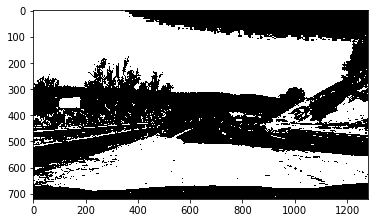

In [70]:
image = mpimg.imread('test_images/difficult2.jpg')
out_image = combined_threshold(image)
plt.imshow(out_image, cmap='gray')

without v and b


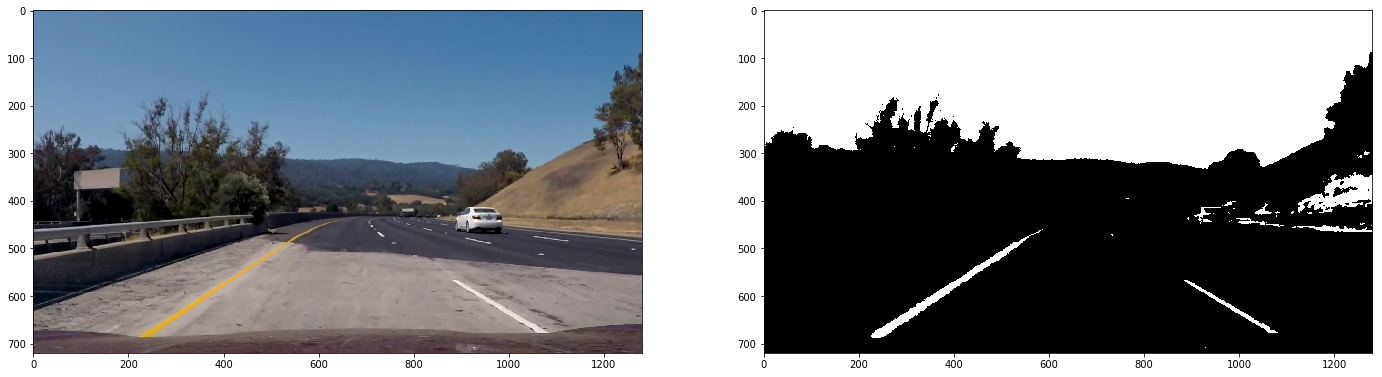

In [107]:
image = mpimg.imread('test_images/difficult2.jpg')
thresholded_image = color_threshold(image, s_thresh=(50, 200), v_thresh=(150, 255), l_thresh=(225, 255), b_thresh=(155, 200))
# thresholded_image = sobelx(image, kernel_size=7, thresh=(20, 120))
# thresholded_image = dir_gradient(image, kernel_size=5, thresh=(0.6, 1.2))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(image)
ax2.imshow(thresholded_image, cmap='gray')


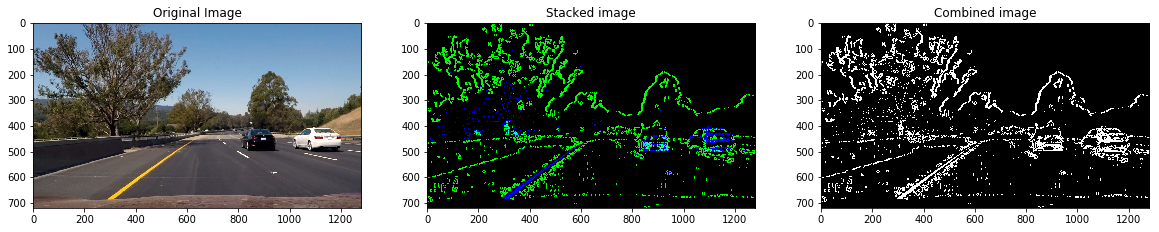

In [14]:
image1 = 'straight_lines1.jpg'
image2 = 'straight_lines2.jpg'
image3 = 'test1.jpg'
image4 = 'test2.jpg'
image5 = 'test3.jpg'
image6 = 'test4.jpg'
image7 = 'test5.jpg'
image8 = 'test6.jpg'
image = mpimg.imread('test_images/'+image8)
stacked, combined = threshold_color_and_gradient(image)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
# f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image')

ax2.imshow(stacked, cmap='gray')
ax2.set_title('Stacked image')

ax3.imshow(combined, cmap='gray')
ax3.set_title('Combined image')
# plt.subplots_adjust(left=0., right=1., top=0.9, bottom=0.)
f.savefig('output_images/threshold_color_and_gradient.png')

### Perpective transform
Now we need to change the image perspective, in order to get a bird's eye view perspective that respresent a more realistic view of the lane lines. To that end we implement the next function:

In [15]:
def warper(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

In [16]:
def warper_inv(warped, Minv, left_fit, right_fit, ploty):
    img_size = (warped.shape[1], warped.shape[0])
#     Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
#     Recast x and y points into usable format to cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fit, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fit, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
#     Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
#     Warp the blank back to original image using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, img_size)
    return newwarp
    

(720, 1280, 3)


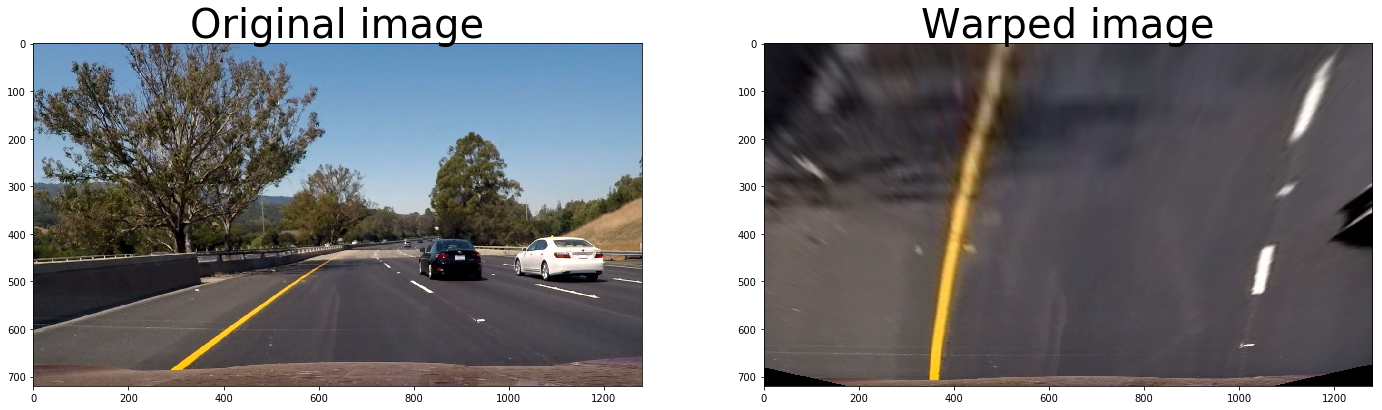

In [17]:
image8 = 'test6.jpg'
image = mpimg.imread('test_images/'+image8)
img_size = (image.shape[1], image.shape[0])
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])


warped, _, _ = warper(image)
print(warped.shape)
mpimg.imsave('output_images/warped', warped)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(image)
ax1.set_title('Original image', fontsize=40)
ax2.imshow(warped)
ax2.set_title('Warped image', fontsize=40)
f.savefig('output_images/warped')

Now we are going to follow the pipeline so far, to undistort an image, apply color and gradient threshold and then change its perpective

(720, 1280)


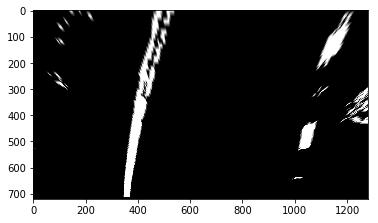

In [18]:
image8 = 'test6.jpg'
image = mpimg.imread('test_images/'+image8)
undistorted = undistort(image, mtx, dist)
# _, binary_img = threshold_color_and_gradient(undistorted)
thresholded = combined_threshold(undistorted)
img_size = (thresholded.shape[1], thresholded.shape[0])
warped_img, _, _ = warper(thresholded)
print(warped_img.shape)
plt.imshow(warped_img, cmap='gray')
plt.imsave('output_images/binary_warped', warped_img, cmap='gray')

### Lane lines detection
Now we can use the sliding window approach and the to detect the left and right lane points to then fit a polynomial that represent each lane


In [19]:
def find_lane_pixels(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    midpoint = np.int(histogram.shape[0]//2)
    left_base = np.argmax(histogram[:midpoint])
    right_base = np.argmax(histogram[midpoint:]) + midpoint
    nwindows = 9
    margin = 100
    minpix = 50
    winheight = np.int(binary_warped.shape[0]//nwindows)
    
    nonzero = binary_warped.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    
    left_lane_inds = []
    right_lane_inds = []
    
    leftx_current = left_base
    rightx_current = right_base
    
    for window in range(nwindows):
        # Boundaries of current window
        winy_high = binary_warped.shape[0] - (window * winheight)
        winy_low = binary_warped.shape[0] - (window + 1) * winheight
        winx_left_low = leftx_current - margin
        winx_left_high = leftx_current + margin
        winx_right_low = rightx_current - margin
        winx_right_high = rightx_current + margin
        
#         cv2.rectangle(out_img, (winx_left_low, winy_low), (winx_left_high, winy_high), (0, 255, 0), 2)
#         cv2.rectangle(out_img, (winx_right_low, winy_low), (winx_right_high, winy_high), (0, 255, 0), 2)
        
        good_left_ind = ((nonzerox > winx_left_low) & (nonzerox < winx_left_high) & (nonzeroy > winy_low) & (nonzeroy < winy_high)).nonzero()[0]
        good_right_ind = ((nonzerox > winx_right_low) & (nonzerox < winx_right_high) & (nonzeroy > winy_low) & (nonzeroy < winy_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_ind)
        right_lane_inds.append(good_right_ind)
        
        if len(good_left_ind) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_ind]))
        if len(good_right_ind) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_ind]))
    
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img

In [20]:
def fit_polynomial(binary_warped):
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except:
        print('The function failed to fit the line')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    # Color the left and right lane line pixels
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    # Draw the polynomial fit
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    return out_img    
    

In [21]:
def fit_poly_pixels(img_shape, leftx, lefty, rightx, righty, ym_per_pix, xm_per_pix):
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_fit_r = np.polyfit(lefty*ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_r = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
        
    poly_params = (left_fit_r, right_fit_r)
    fitted_lines_coord = (left_fitx, right_fitx, ploty)
    
    return poly_params, fitted_lines_coord


In [22]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ym_per_pix = 30 / 720
    xm_per_pix = 3.7 / 700

    left_fit = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    return left_fitx, right_fitx, ploty

In [23]:
def search_around_poly(binary_warped, left_fit, right_fit, xm_per_pix, ym_per_pix):
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###

    x_points_line1 = left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2]
    x_points_line2 = right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2]
    left_lane_inds = ((nonzerox > (x_points_line1 - margin)) & (nonzerox < (x_points_line1 + margin)))
    right_lane_inds = ((nonzerox > (x_points_line2 - margin)) & (nonzerox < (x_points_line2 + margin)))

    # Extract the left and right lines pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # fit new polynomials
    # TODO change to meassure real world to compute well the curvature
#     left_fitx, right_fix, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    poly_params, lines_coord = fit_poly_pixels(binary_warped.shape, leftx, lefty, rightx, righty, ym_per_pix, xm_per_pix)
    
    leftx, rightx, ploty = lines_coord
    car_position = binary_warped.shape[1] / 2
    lane_center = leftx[-1] + rightx[-1] / 2
    center_dist = (car_position - lane_center) * xm_per_pix

#     # Visuatization
#     # Create an image to draw on and an image to show the selection window
#     out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
#     window_img = np.zeros_like(out_img)
#     # Color in left and right line pixels
#     out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#     out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# #     Generate a Polygon to illustrate the search window area
# #     And recast x and y points into usable format to cv2.fillPoly()
#     left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
#     left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])

#     left_line_pts = np.hstack((left_line_window1, left_line_window2))
#     right_line_window1 = np.array([np.transpose(np.vstack([right_fix-margin, ploty]))])
#     right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fix+margin, ploty])))])
#     right_line_pts = np.hstack((right_line_window1, right_line_window2))

# #     Draw the lane onto the warped blank image
#     cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
#     cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
#     result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

#     plot the polynomial lines onto the image
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fix, ploty, color='yellow')

    return poly_params, lines_coord, center_dist

In [24]:
def sliding_window_search(binary_warped, ym_per_pix, xm_per_pix):
    margin = 100
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    poly_params, fitted_lines_coord = fit_poly_pixels(binary_warped.shape, leftx, lefty, rightx, righty, ym_per_pix, xm_per_pix)

    window_img = np.zeros_like(out_img)

    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    leftx, rightx, ploty = fitted_lines_coord
    car_position = binary_warped.shape[1] / 2
    lane_center = leftx[-1] + rightx[-1] / 2
    center_dist = (car_position - lane_center) * xm_per_pix
    

    #     Generate a Polygon to illustrate the search window area
    #     And recast x and y points into usable format to cv2.fillPoly()
#     left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
#     left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])

#     left_line_pts = np.hstack((left_line_window1, left_line_window2))
#     right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
#     right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
#     right_line_pts = np.hstack((right_line_window1, right_line_window2))

#     #     Draw the lane onto the warped blank image
#     cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
#     cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
#     result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Draw the polynomial fit
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
    return out_img, poly_params, fitted_lines_coord, center_dist

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


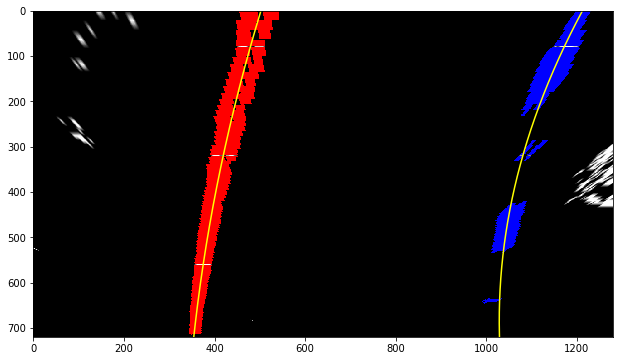

In [25]:
# image = mpimg.imread('output_images/binary_warped.png')
# print(warped_img.shape)
plt.figure(figsize = (80,6))
plt.imshow(warped_img, interpolation='nearest', aspect='auto')
fitted_image = fit_polynomial(warped_img)
plt.imshow(fitted_image)

### Curvature
The next step is compute the curvature of the lane line. First we are going to compute the pixels curvature and then we are going to compute the real world curvature

In [26]:
def measure_curvature_pixels(ploty, left_fit, right_fit):
    y_eval = np.max(ploty)

    # Calculation of R_curve (radius of curvature)
    left_curverad = (1 + (2 * left_fit[0] * y_eval + left_fit[1]) ** 2) ** (3 / 2) / np.absolute(2 * left_fit[0])
    right_curverad = (1 + (2 * right_fit[0] * y_eval + right_fit[1]) ** 2) ** (3 / 2) / np.absolute(2 * right_fit[0])

    return left_curverad, right_curverad


In [27]:
def measure_curvature_real(ploty, left_fit_cr, right_fit_cr, ym_per_pix, xm_per_pix):    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = (1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** (3 / 2) / np.absolute(
        2 * left_fit_cr[0])
    right_curverad = (1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** (3 / 2) / np.absolute(
        2 * right_fit_cr[0])
    
    return left_curverad, right_curverad

In [28]:
def pipeline(image, mtx, dist, left_fit=None, right_fit=None, ym_per_pix=15/720, xm_per_pix=3.7/650):
    undistorted = undistort(image, mtx, dist)
    print('undistorted shape ', undistorted.shape)
    thresholded = combined_threshold(undistorted)
    warped, M, Minv = warper(thresholded)
#     plt.imshow(warped)
    print('warped shape ', warped.shape)
    if left_fit is not None and right_fit is not None:
        poly_params, fitted_lines_coord, center_dist = search_around_poly(warped, left_fit, right_fit, ym_per_pix, xm_per_pix)
#         out_img, left_fit, right_fit, ploty = search_around_poly(warped, left_fit, right_fit)
    else:
        out_img, poly_params, fitted_lines_coord, center_dist = sliding_window_search(warped, ym_per_pix, xm_per_pix)
        
    left_fit, right_fit = poly_params
    left_fitx, right_fitx, ploty = fitted_lines_coord

    left_curv, right_curv = measure_curvature_real(ploty, left_fit, right_fit, ym_per_pix, xm_per_pix)
    lane_img = warper_inv(warped, Minv, left_fitx, right_fitx, ploty)
    road_img = cv2.addWeighted(undistorted, 1, lane_img, 0.3, 0)
    
    car_direction = 'right' if center_dist > 0 else 'left'
    
    mean_curvature = (left_curv + right_curv) / 2
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(road_img, 'Radius Curvature: {0:.2f} (m)'.format(mean_curvature), (50,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(road_img, 'Vehicle is {:04.3f} (m)'.format(abs(center_dist)) + ' {} from center'.format(car_direction), (50,100), font, 1,(255,255,255),2,cv2.LINE_AA)
    plt.imshow(road_img)
    return road_img, poly_params

In [29]:
image = mpimg.imread('test_images/test6.jpg')
mtx, dist = calibrate_camera('camera_cal', 9, 6)

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


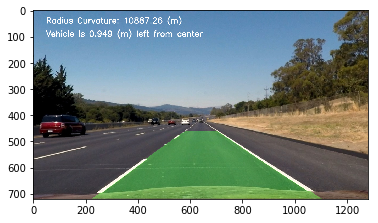

In [30]:
image = mpimg.imread('test_images/straight_lines2.jpg')
out_img, _ = pipeline(image, mtx, dist)
plt.imshow(out_img)
plt.imsave('output_images/filled_lane', out_img)

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


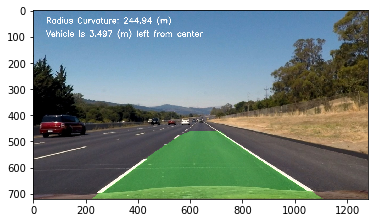

In [31]:
left_fit = np.array([1.35731604e-04, -3.03490785e-01, 5.02378752e+02])
right_fit = np.array([3.92766376e-04, -5.37018058e-01, 1.21213132e+03])
out_img, poly_params = pipeline(image, mtx, dist, left_fit, right_fit)
left_fit, right_fit = poly_params
plt.imshow(out_img)

In [65]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [66]:
def process_image(image):
    result, _ = pipeline(image, mtx, dist)
    return result

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)
[MoviePy] >>>> Building video output_images/my_output.mp4
[MoviePy] Writing video output_images/my_output.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


  0%|          | 1/1261 [00:00<07:15,  2.89it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


  0%|          | 2/1261 [00:00<07:09,  2.93it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


  0%|          | 3/1261 [00:00<06:54,  3.03it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


  0%|          | 4/1261 [00:01<06:50,  3.06it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


  0%|          | 5/1261 [00:01<07:03,  2.97it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


  0%|          | 6/1261 [00:02<07:07,  2.94it/s]

undistorted shape  (720, 1280, 3)


  1%|          | 7/1261 [00:02<07:19,  2.85it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  1%|          | 8/1261 [00:02<06:52,  3.04it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  1%|          | 9/1261 [00:02<06:34,  3.17it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  1%|          | 10/1261 [00:03<06:23,  3.26it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  1%|          | 11/1261 [00:03<06:11,  3.36it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  1%|          | 12/1261 [00:03<06:02,  3.45it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  1%|          | 13/1261 [00:04<06:00,  3.46it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  1%|          | 14/1261 [00:04<05:56,  3.49it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  1%|          | 15/1261 [00:04<05:53,  3.53it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  1%|▏         | 16/1261 [00:04<05:55,  3.50it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  1%|▏         | 17/1261 [00:05<05:53,  3.52it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  1%|▏         | 18/1261 [00:05<05:56,  3.49it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  2%|▏         | 19/1261 [00:05<06:01,  3.44it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  2%|▏         | 20/1261 [00:06<06:01,  3.43it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  2%|▏         | 21/1261 [00:06<06:03,  3.41it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  2%|▏         | 22/1261 [00:06<05:59,  3.45it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  2%|▏         | 23/1261 [00:06<06:03,  3.41it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  2%|▏         | 24/1261 [00:07<05:54,  3.49it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  2%|▏         | 25/1261 [00:07<05:51,  3.52it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  2%|▏         | 26/1261 [00:07<05:48,  3.55it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  2%|▏         | 27/1261 [00:08<05:48,  3.54it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  2%|▏         | 28/1261 [00:08<05:44,  3.58it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  2%|▏         | 29/1261 [00:08<05:40,  3.62it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  2%|▏         | 30/1261 [00:08<05:40,  3.62it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  2%|▏         | 31/1261 [00:09<05:41,  3.60it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  3%|▎         | 32/1261 [00:09<05:42,  3.59it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  3%|▎         | 33/1261 [00:09<05:41,  3.59it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  3%|▎         | 34/1261 [00:10<05:51,  3.49it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  3%|▎         | 35/1261 [00:10<05:44,  3.56it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  3%|▎         | 36/1261 [00:10<05:44,  3.56it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  3%|▎         | 37/1261 [00:10<05:37,  3.63it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  3%|▎         | 38/1261 [00:11<05:35,  3.65it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  3%|▎         | 39/1261 [00:11<05:28,  3.71it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  3%|▎         | 40/1261 [00:11<05:32,  3.68it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  3%|▎         | 41/1261 [00:11<05:33,  3.66it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  3%|▎         | 42/1261 [00:12<06:09,  3.30it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  3%|▎         | 43/1261 [00:12<06:34,  3.09it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  3%|▎         | 44/1261 [00:12<06:27,  3.14it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  4%|▎         | 45/1261 [00:13<06:25,  3.15it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  4%|▎         | 46/1261 [00:13<06:46,  2.99it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  4%|▎         | 47/1261 [00:14<06:45,  3.00it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  4%|▍         | 48/1261 [00:14<06:26,  3.14it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  4%|▍         | 49/1261 [00:14<06:08,  3.29it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  4%|▍         | 50/1261 [00:14<06:25,  3.14it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  4%|▍         | 51/1261 [00:15<06:06,  3.30it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  4%|▍         | 52/1261 [00:15<05:57,  3.38it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  4%|▍         | 53/1261 [00:15<05:42,  3.52it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  4%|▍         | 54/1261 [00:15<05:37,  3.57it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  4%|▍         | 55/1261 [00:16<05:35,  3.59it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  4%|▍         | 56/1261 [00:16<05:44,  3.50it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  5%|▍         | 57/1261 [00:16<05:36,  3.58it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  5%|▍         | 58/1261 [00:17<05:30,  3.64it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  5%|▍         | 59/1261 [00:17<06:10,  3.24it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  5%|▍         | 60/1261 [00:17<07:11,  2.78it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  5%|▍         | 61/1261 [00:18<06:53,  2.90it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  5%|▍         | 62/1261 [00:18<06:21,  3.14it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  5%|▍         | 63/1261 [00:18<06:12,  3.22it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  5%|▌         | 64/1261 [00:19<06:08,  3.25it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  5%|▌         | 65/1261 [00:19<06:00,  3.31it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  5%|▌         | 66/1261 [00:19<05:43,  3.48it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  5%|▌         | 67/1261 [00:19<05:47,  3.44it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  5%|▌         | 68/1261 [00:20<05:43,  3.48it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  5%|▌         | 69/1261 [00:20<05:33,  3.57it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  6%|▌         | 70/1261 [00:20<05:29,  3.61it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  6%|▌         | 71/1261 [00:21<05:30,  3.60it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  6%|▌         | 72/1261 [00:21<05:27,  3.63it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  6%|▌         | 73/1261 [00:21<05:19,  3.72it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  6%|▌         | 74/1261 [00:21<05:19,  3.72it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  6%|▌         | 75/1261 [00:22<05:14,  3.78it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  6%|▌         | 76/1261 [00:22<05:14,  3.77it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  6%|▌         | 77/1261 [00:22<05:09,  3.82it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  6%|▌         | 78/1261 [00:22<05:06,  3.85it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  6%|▋         | 79/1261 [00:23<05:11,  3.79it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  6%|▋         | 80/1261 [00:23<05:16,  3.74it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  6%|▋         | 81/1261 [00:23<05:14,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  7%|▋         | 82/1261 [00:23<05:08,  3.82it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  7%|▋         | 83/1261 [00:24<05:08,  3.82it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  7%|▋         | 84/1261 [00:24<05:26,  3.61it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  7%|▋         | 85/1261 [00:24<05:46,  3.39it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  7%|▋         | 86/1261 [00:25<05:43,  3.42it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  7%|▋         | 87/1261 [00:25<06:37,  2.95it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


  7%|▋         | 88/1261 [00:25<06:38,  2.95it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


  7%|▋         | 89/1261 [00:26<06:13,  3.14it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


  7%|▋         | 90/1261 [00:26<06:25,  3.04it/s]

undistorted shape  (720, 1280, 3)


  7%|▋         | 91/1261 [00:26<07:06,  2.74it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  7%|▋         | 92/1261 [00:27<07:28,  2.61it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  7%|▋         | 93/1261 [00:27<06:58,  2.79it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  7%|▋         | 94/1261 [00:27<06:23,  3.04it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  8%|▊         | 95/1261 [00:28<06:32,  2.97it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  8%|▊         | 96/1261 [00:28<06:16,  3.10it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  8%|▊         | 97/1261 [00:28<05:53,  3.30it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  8%|▊         | 98/1261 [00:29<05:42,  3.40it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  8%|▊         | 99/1261 [00:29<05:36,  3.46it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  8%|▊         | 100/1261 [00:29<05:29,  3.52it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  8%|▊         | 101/1261 [00:29<05:28,  3.53it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  8%|▊         | 102/1261 [00:30<05:26,  3.55it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  8%|▊         | 103/1261 [00:30<05:19,  3.63it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  8%|▊         | 104/1261 [00:30<05:26,  3.55it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  8%|▊         | 105/1261 [00:31<05:17,  3.64it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  8%|▊         | 106/1261 [00:31<05:19,  3.61it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  8%|▊         | 107/1261 [00:31<05:56,  3.23it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  9%|▊         | 108/1261 [00:32<05:43,  3.36it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  9%|▊         | 109/1261 [00:32<05:27,  3.52it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  9%|▊         | 110/1261 [00:32<05:16,  3.63it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  9%|▉         | 111/1261 [00:32<05:10,  3.71it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  9%|▉         | 112/1261 [00:33<05:10,  3.70it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  9%|▉         | 113/1261 [00:33<05:03,  3.79it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  9%|▉         | 114/1261 [00:33<04:57,  3.86it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  9%|▉         | 115/1261 [00:33<04:56,  3.87it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  9%|▉         | 116/1261 [00:34<05:02,  3.78it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  9%|▉         | 117/1261 [00:34<05:01,  3.80it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  9%|▉         | 118/1261 [00:34<05:00,  3.80it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


  9%|▉         | 119/1261 [00:34<04:57,  3.84it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 10%|▉         | 120/1261 [00:35<05:03,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 10%|▉         | 121/1261 [00:35<04:59,  3.81it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 10%|▉         | 122/1261 [00:35<04:56,  3.85it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 10%|▉         | 123/1261 [00:35<04:54,  3.86it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 10%|▉         | 124/1261 [00:36<04:59,  3.80it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 10%|▉         | 125/1261 [00:36<04:54,  3.86it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 10%|▉         | 126/1261 [00:36<04:50,  3.91it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 10%|█         | 127/1261 [00:36<04:51,  3.89it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 10%|█         | 128/1261 [00:37<04:53,  3.86it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 10%|█         | 129/1261 [00:37<04:55,  3.83it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 10%|█         | 130/1261 [00:37<04:53,  3.86it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 10%|█         | 131/1261 [00:37<04:56,  3.81it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 10%|█         | 132/1261 [00:38<05:25,  3.47it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 11%|█         | 133/1261 [00:38<05:38,  3.33it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 11%|█         | 134/1261 [00:38<05:38,  3.32it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 11%|█         | 135/1261 [00:39<05:48,  3.23it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 11%|█         | 136/1261 [00:39<05:54,  3.17it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 11%|█         | 137/1261 [00:39<05:48,  3.23it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 11%|█         | 138/1261 [00:40<05:54,  3.17it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 11%|█         | 139/1261 [00:40<06:11,  3.02it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 11%|█         | 140/1261 [00:40<06:20,  2.95it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 11%|█         | 141/1261 [00:41<06:07,  3.05it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 11%|█▏        | 142/1261 [00:41<05:47,  3.22it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 11%|█▏        | 143/1261 [00:41<05:38,  3.30it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 11%|█▏        | 144/1261 [00:42<05:38,  3.30it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 11%|█▏        | 145/1261 [00:42<05:30,  3.38it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 12%|█▏        | 146/1261 [00:42<05:25,  3.42it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 12%|█▏        | 147/1261 [00:42<05:27,  3.40it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 12%|█▏        | 148/1261 [00:43<05:25,  3.42it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 12%|█▏        | 149/1261 [00:43<05:21,  3.45it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 12%|█▏        | 150/1261 [00:43<05:35,  3.31it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 12%|█▏        | 151/1261 [00:44<05:30,  3.35it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 12%|█▏        | 152/1261 [00:44<05:26,  3.40it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 12%|█▏        | 153/1261 [00:44<05:24,  3.41it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 12%|█▏        | 154/1261 [00:45<05:21,  3.45it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 12%|█▏        | 155/1261 [00:45<05:31,  3.34it/s]

undistorted shape  (720, 1280, 3)


 12%|█▏        | 156/1261 [00:45<05:44,  3.21it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 12%|█▏        | 157/1261 [00:46<05:36,  3.28it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 13%|█▎        | 158/1261 [00:46<05:29,  3.35it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 13%|█▎        | 159/1261 [00:46<05:24,  3.40it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 13%|█▎        | 160/1261 [00:46<05:24,  3.39it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 13%|█▎        | 161/1261 [00:47<05:22,  3.41it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 13%|█▎        | 162/1261 [00:47<05:16,  3.47it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 13%|█▎        | 163/1261 [00:47<05:14,  3.49it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 13%|█▎        | 164/1261 [00:48<05:22,  3.40it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 13%|█▎        | 165/1261 [00:48<05:26,  3.35it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 13%|█▎        | 166/1261 [00:48<05:27,  3.34it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 13%|█▎        | 167/1261 [00:48<05:27,  3.34it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 13%|█▎        | 168/1261 [00:49<05:34,  3.27it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 13%|█▎        | 169/1261 [00:49<05:38,  3.23it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 13%|█▎        | 170/1261 [00:49<05:38,  3.22it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 14%|█▎        | 171/1261 [00:50<05:26,  3.34it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 14%|█▎        | 172/1261 [00:50<05:22,  3.38it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 14%|█▎        | 173/1261 [00:50<05:21,  3.39it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 14%|█▍        | 174/1261 [00:51<05:20,  3.39it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 14%|█▍        | 175/1261 [00:51<05:13,  3.47it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 14%|█▍        | 176/1261 [00:51<05:21,  3.37it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 14%|█▍        | 177/1261 [00:51<05:21,  3.37it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 14%|█▍        | 178/1261 [00:52<05:17,  3.41it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 14%|█▍        | 179/1261 [00:52<05:09,  3.49it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 14%|█▍        | 180/1261 [00:52<05:15,  3.43it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 14%|█▍        | 181/1261 [00:53<05:14,  3.43it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 14%|█▍        | 182/1261 [00:53<05:10,  3.48it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 15%|█▍        | 183/1261 [00:53<05:08,  3.49it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 15%|█▍        | 184/1261 [00:53<05:16,  3.41it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 15%|█▍        | 185/1261 [00:54<05:10,  3.46it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 15%|█▍        | 186/1261 [00:54<05:08,  3.49it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 15%|█▍        | 187/1261 [00:54<05:04,  3.53it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 15%|█▍        | 188/1261 [00:55<05:10,  3.46it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 15%|█▍        | 189/1261 [00:55<05:04,  3.52it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 15%|█▌        | 190/1261 [00:55<05:07,  3.49it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 15%|█▌        | 191/1261 [00:55<05:01,  3.55it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 15%|█▌        | 192/1261 [00:56<05:12,  3.42it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 15%|█▌        | 193/1261 [00:56<05:10,  3.44it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 15%|█▌        | 194/1261 [00:56<05:02,  3.52it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 15%|█▌        | 195/1261 [00:57<05:11,  3.43it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 16%|█▌        | 196/1261 [00:57<05:12,  3.41it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 16%|█▌        | 197/1261 [00:57<05:06,  3.47it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 16%|█▌        | 198/1261 [00:57<05:10,  3.43it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 16%|█▌        | 199/1261 [00:58<05:13,  3.39it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 16%|█▌        | 200/1261 [00:58<05:15,  3.36it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 16%|█▌        | 201/1261 [00:58<05:10,  3.41it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 16%|█▌        | 202/1261 [00:59<05:15,  3.35it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 16%|█▌        | 203/1261 [00:59<05:08,  3.43it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 16%|█▌        | 204/1261 [00:59<05:14,  3.36it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 16%|█▋        | 205/1261 [01:00<05:06,  3.45it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 16%|█▋        | 206/1261 [01:00<05:06,  3.44it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 16%|█▋        | 207/1261 [01:00<05:02,  3.48it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 16%|█▋        | 208/1261 [01:00<05:11,  3.38it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 17%|█▋        | 209/1261 [01:01<05:14,  3.34it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 17%|█▋        | 210/1261 [01:01<05:06,  3.42it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 17%|█▋        | 211/1261 [01:01<05:05,  3.44it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 17%|█▋        | 212/1261 [01:02<05:08,  3.40it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 17%|█▋        | 213/1261 [01:02<05:10,  3.38it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 17%|█▋        | 214/1261 [01:02<05:00,  3.49it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 17%|█▋        | 215/1261 [01:02<04:58,  3.51it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 17%|█▋        | 216/1261 [01:03<05:05,  3.42it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 17%|█▋        | 217/1261 [01:03<05:07,  3.40it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 17%|█▋        | 218/1261 [01:03<05:07,  3.39it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 17%|█▋        | 219/1261 [01:04<05:02,  3.45it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 17%|█▋        | 220/1261 [01:04<05:02,  3.44it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 18%|█▊        | 221/1261 [01:04<05:01,  3.45it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 18%|█▊        | 222/1261 [01:05<05:09,  3.36it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 18%|█▊        | 223/1261 [01:05<05:11,  3.33it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 18%|█▊        | 224/1261 [01:05<05:11,  3.33it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 18%|█▊        | 225/1261 [01:05<05:06,  3.38it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 18%|█▊        | 226/1261 [01:06<05:02,  3.42it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 18%|█▊        | 227/1261 [01:06<04:53,  3.52it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 18%|█▊        | 228/1261 [01:06<04:55,  3.49it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 18%|█▊        | 229/1261 [01:07<05:01,  3.42it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 18%|█▊        | 230/1261 [01:07<04:58,  3.45it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 18%|█▊        | 231/1261 [01:07<04:56,  3.47it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 18%|█▊        | 232/1261 [01:07<05:16,  3.25it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 18%|█▊        | 233/1261 [01:08<05:15,  3.25it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 19%|█▊        | 234/1261 [01:08<05:12,  3.28it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 19%|█▊        | 235/1261 [01:08<05:14,  3.26it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 19%|█▊        | 236/1261 [01:09<05:25,  3.15it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 19%|█▉        | 237/1261 [01:09<05:16,  3.23it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 19%|█▉        | 238/1261 [01:09<05:19,  3.20it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 19%|█▉        | 239/1261 [01:10<05:18,  3.21it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 19%|█▉        | 240/1261 [01:10<05:16,  3.23it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 19%|█▉        | 241/1261 [01:10<06:22,  2.66it/s]

undistorted shape  (720, 1280, 3)


 19%|█▉        | 242/1261 [01:11<06:19,  2.69it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 19%|█▉        | 243/1261 [01:11<05:56,  2.86it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 19%|█▉        | 244/1261 [01:12<05:57,  2.85it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 19%|█▉        | 245/1261 [01:12<05:47,  2.92it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 20%|█▉        | 246/1261 [01:12<05:29,  3.08it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 20%|█▉        | 247/1261 [01:12<05:23,  3.14it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 20%|█▉        | 248/1261 [01:13<05:24,  3.12it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 20%|█▉        | 249/1261 [01:13<05:17,  3.19it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 20%|█▉        | 250/1261 [01:13<05:15,  3.21it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 20%|█▉        | 251/1261 [01:14<05:11,  3.24it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 20%|█▉        | 252/1261 [01:14<05:17,  3.18it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 20%|██        | 253/1261 [01:14<05:23,  3.11it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 20%|██        | 254/1261 [01:15<05:14,  3.20it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 20%|██        | 255/1261 [01:15<05:05,  3.29it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 20%|██        | 256/1261 [01:15<05:04,  3.30it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 20%|██        | 257/1261 [01:15<05:01,  3.33it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 20%|██        | 258/1261 [01:16<05:04,  3.29it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 21%|██        | 259/1261 [01:16<05:03,  3.30it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 21%|██        | 260/1261 [01:16<05:04,  3.29it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 21%|██        | 261/1261 [01:17<04:58,  3.35it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 21%|██        | 262/1261 [01:17<04:50,  3.44it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 21%|██        | 263/1261 [01:17<04:48,  3.46it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 21%|██        | 264/1261 [01:18<05:00,  3.32it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 21%|██        | 265/1261 [01:18<04:55,  3.37it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 21%|██        | 266/1261 [01:18<04:57,  3.34it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 21%|██        | 267/1261 [01:18<04:51,  3.41it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 21%|██▏       | 268/1261 [01:19<06:07,  2.70it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 21%|██▏       | 269/1261 [01:20<06:53,  2.40it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 21%|██▏       | 270/1261 [01:20<06:18,  2.62it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 21%|██▏       | 271/1261 [01:20<05:49,  2.83it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 22%|██▏       | 272/1261 [01:20<05:33,  2.97it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 22%|██▏       | 273/1261 [01:21<05:17,  3.11it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 22%|██▏       | 274/1261 [01:21<05:02,  3.26it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 22%|██▏       | 275/1261 [01:21<04:54,  3.35it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 22%|██▏       | 276/1261 [01:22<04:56,  3.32it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 22%|██▏       | 277/1261 [01:22<05:19,  3.08it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 22%|██▏       | 278/1261 [01:22<05:17,  3.10it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 22%|██▏       | 279/1261 [01:23<05:13,  3.14it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 22%|██▏       | 280/1261 [01:23<05:07,  3.19it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 22%|██▏       | 281/1261 [01:23<05:01,  3.25it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 22%|██▏       | 282/1261 [01:23<04:53,  3.34it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 22%|██▏       | 283/1261 [01:24<04:47,  3.41it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 23%|██▎       | 284/1261 [01:24<04:46,  3.41it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 23%|██▎       | 285/1261 [01:24<04:48,  3.38it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 23%|██▎       | 286/1261 [01:25<04:48,  3.37it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 23%|██▎       | 287/1261 [01:25<04:41,  3.46it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 23%|██▎       | 288/1261 [01:25<04:43,  3.44it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 23%|██▎       | 289/1261 [01:25<04:44,  3.41it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 23%|██▎       | 290/1261 [01:26<04:42,  3.43it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 23%|██▎       | 291/1261 [01:26<04:38,  3.48it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 23%|██▎       | 292/1261 [01:26<04:41,  3.44it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 23%|██▎       | 293/1261 [01:27<04:56,  3.27it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 23%|██▎       | 294/1261 [01:27<04:51,  3.31it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 23%|██▎       | 295/1261 [01:27<04:44,  3.39it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 23%|██▎       | 296/1261 [01:28<04:42,  3.41it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 24%|██▎       | 297/1261 [01:28<04:34,  3.51it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 24%|██▎       | 298/1261 [01:28<04:33,  3.52it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 24%|██▎       | 299/1261 [01:28<04:30,  3.55it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 24%|██▍       | 300/1261 [01:29<04:29,  3.57it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 24%|██▍       | 301/1261 [01:29<04:35,  3.49it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 24%|██▍       | 302/1261 [01:29<04:42,  3.40it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 24%|██▍       | 303/1261 [01:30<04:51,  3.29it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 24%|██▍       | 304/1261 [01:30<04:42,  3.39it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 24%|██▍       | 305/1261 [01:30<04:37,  3.45it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 24%|██▍       | 306/1261 [01:30<04:42,  3.38it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 24%|██▍       | 307/1261 [01:31<04:41,  3.39it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 24%|██▍       | 308/1261 [01:31<04:41,  3.38it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 25%|██▍       | 309/1261 [01:31<04:37,  3.44it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 25%|██▍       | 310/1261 [01:32<04:51,  3.27it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 25%|██▍       | 311/1261 [01:32<05:06,  3.10it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 25%|██▍       | 312/1261 [01:32<05:44,  2.75it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 25%|██▍       | 313/1261 [01:33<06:02,  2.61it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 25%|██▍       | 314/1261 [01:33<05:27,  2.89it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 25%|██▍       | 315/1261 [01:34<05:25,  2.90it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 25%|██▌       | 316/1261 [01:34<05:20,  2.95it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 25%|██▌       | 317/1261 [01:34<04:59,  3.15it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 25%|██▌       | 318/1261 [01:34<04:57,  3.17it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 25%|██▌       | 319/1261 [01:35<05:03,  3.10it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 25%|██▌       | 320/1261 [01:35<04:59,  3.14it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 25%|██▌       | 321/1261 [01:35<05:14,  2.99it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 26%|██▌       | 322/1261 [01:36<05:04,  3.08it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 26%|██▌       | 323/1261 [01:36<04:43,  3.30it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 26%|██▌       | 324/1261 [01:36<04:29,  3.47it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 26%|██▌       | 325/1261 [01:37<04:24,  3.54it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 26%|██▌       | 326/1261 [01:37<04:18,  3.62it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 26%|██▌       | 327/1261 [01:37<04:27,  3.50it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 26%|██▌       | 328/1261 [01:37<04:20,  3.58it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 26%|██▌       | 329/1261 [01:38<04:12,  3.69it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 26%|██▌       | 330/1261 [01:38<04:10,  3.71it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 26%|██▌       | 331/1261 [01:38<04:07,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 26%|██▋       | 332/1261 [01:38<04:05,  3.78it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 26%|██▋       | 333/1261 [01:39<04:02,  3.83it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 26%|██▋       | 334/1261 [01:39<04:05,  3.78it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 27%|██▋       | 335/1261 [01:39<04:06,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 27%|██▋       | 336/1261 [01:39<04:10,  3.70it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 27%|██▋       | 337/1261 [01:40<04:11,  3.68it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 27%|██▋       | 338/1261 [01:40<04:09,  3.70it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 27%|██▋       | 339/1261 [01:40<04:10,  3.68it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 27%|██▋       | 340/1261 [01:41<04:05,  3.75it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 27%|██▋       | 341/1261 [01:41<04:03,  3.79it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 27%|██▋       | 342/1261 [01:41<04:03,  3.78it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 27%|██▋       | 343/1261 [01:41<04:08,  3.70it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 27%|██▋       | 344/1261 [01:42<04:03,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 27%|██▋       | 345/1261 [01:42<04:06,  3.72it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 27%|██▋       | 346/1261 [01:42<04:06,  3.72it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 28%|██▊       | 347/1261 [01:42<04:08,  3.67it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 28%|██▊       | 348/1261 [01:43<04:12,  3.62it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 28%|██▊       | 349/1261 [01:43<04:06,  3.70it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 28%|██▊       | 350/1261 [01:43<04:06,  3.69it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 28%|██▊       | 351/1261 [01:44<04:19,  3.51it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 28%|██▊       | 352/1261 [01:44<04:12,  3.60it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 28%|██▊       | 353/1261 [01:44<04:04,  3.72it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 28%|██▊       | 354/1261 [01:44<04:09,  3.64it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 28%|██▊       | 355/1261 [01:45<04:05,  3.70it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 28%|██▊       | 356/1261 [01:45<04:01,  3.75it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 28%|██▊       | 357/1261 [01:45<04:02,  3.72it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 28%|██▊       | 358/1261 [01:45<04:09,  3.63it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 28%|██▊       | 359/1261 [01:46<04:03,  3.70it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 29%|██▊       | 360/1261 [01:46<04:09,  3.61it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 29%|██▊       | 361/1261 [01:46<04:05,  3.67it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 29%|██▊       | 362/1261 [01:47<04:11,  3.57it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 29%|██▉       | 363/1261 [01:47<04:05,  3.66it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 29%|██▉       | 364/1261 [01:47<04:02,  3.70it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 29%|██▉       | 365/1261 [01:47<04:04,  3.67it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 29%|██▉       | 366/1261 [01:48<04:01,  3.70it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 29%|██▉       | 367/1261 [01:48<03:57,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 29%|██▉       | 368/1261 [01:48<03:53,  3.83it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 29%|██▉       | 369/1261 [01:48<03:53,  3.81it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 29%|██▉       | 370/1261 [01:49<03:59,  3.73it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 29%|██▉       | 371/1261 [01:49<03:56,  3.77it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 30%|██▉       | 372/1261 [01:49<03:54,  3.79it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 30%|██▉       | 373/1261 [01:49<03:53,  3.80it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 30%|██▉       | 374/1261 [01:50<04:02,  3.66it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 30%|██▉       | 375/1261 [01:50<03:59,  3.70it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 30%|██▉       | 376/1261 [01:50<03:56,  3.74it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 30%|██▉       | 377/1261 [01:51<03:55,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 30%|██▉       | 378/1261 [01:51<03:58,  3.70it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 30%|███       | 379/1261 [01:51<03:54,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 30%|███       | 380/1261 [01:51<03:55,  3.74it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 30%|███       | 381/1261 [01:52<03:51,  3.80it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 30%|███       | 382/1261 [01:52<03:51,  3.80it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 30%|███       | 383/1261 [01:52<03:53,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 30%|███       | 384/1261 [01:52<03:55,  3.72it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 31%|███       | 385/1261 [01:53<03:52,  3.77it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 31%|███       | 386/1261 [01:53<03:54,  3.73it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 31%|███       | 387/1261 [01:53<03:52,  3.75it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 31%|███       | 388/1261 [01:53<03:54,  3.72it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 31%|███       | 389/1261 [01:54<03:49,  3.80it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 31%|███       | 390/1261 [01:54<03:50,  3.77it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 31%|███       | 391/1261 [01:54<03:49,  3.80it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 31%|███       | 392/1261 [01:55<03:52,  3.74it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 31%|███       | 393/1261 [01:55<03:48,  3.79it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 31%|███       | 394/1261 [01:55<03:54,  3.69it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 31%|███▏      | 395/1261 [01:55<03:52,  3.72it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 31%|███▏      | 396/1261 [01:56<03:50,  3.75it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 31%|███▏      | 397/1261 [01:56<03:45,  3.82it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 32%|███▏      | 398/1261 [01:56<03:51,  3.72it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 32%|███▏      | 399/1261 [01:56<03:51,  3.72it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 32%|███▏      | 400/1261 [01:57<03:48,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 32%|███▏      | 401/1261 [01:57<03:44,  3.84it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 32%|███▏      | 402/1261 [01:57<03:45,  3.80it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 32%|███▏      | 403/1261 [01:57<03:52,  3.70it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 32%|███▏      | 404/1261 [01:58<03:48,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 32%|███▏      | 405/1261 [01:58<03:46,  3.79it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 32%|███▏      | 406/1261 [01:58<03:48,  3.74it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 32%|███▏      | 407/1261 [01:59<03:53,  3.66it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 32%|███▏      | 408/1261 [01:59<03:47,  3.74it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 32%|███▏      | 409/1261 [01:59<03:43,  3.81it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 33%|███▎      | 410/1261 [01:59<03:49,  3.70it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 33%|███▎      | 411/1261 [02:00<03:47,  3.74it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 33%|███▎      | 412/1261 [02:00<03:45,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 33%|███▎      | 413/1261 [02:00<03:41,  3.84it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 33%|███▎      | 414/1261 [02:00<03:45,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 33%|███▎      | 415/1261 [02:01<03:43,  3.79it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 33%|███▎      | 416/1261 [02:01<03:42,  3.80it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 33%|███▎      | 417/1261 [02:01<03:40,  3.84it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 33%|███▎      | 418/1261 [02:01<03:46,  3.72it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 33%|███▎      | 419/1261 [02:02<03:43,  3.77it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 33%|███▎      | 420/1261 [02:02<03:44,  3.75it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 33%|███▎      | 421/1261 [02:02<03:42,  3.78it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 33%|███▎      | 422/1261 [02:03<03:49,  3.65it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 34%|███▎      | 423/1261 [02:03<03:45,  3.72it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 34%|███▎      | 424/1261 [02:03<03:41,  3.78it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 34%|███▎      | 425/1261 [02:03<03:42,  3.75it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 34%|███▍      | 426/1261 [02:04<03:48,  3.66it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 34%|███▍      | 427/1261 [02:04<03:43,  3.73it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 34%|███▍      | 428/1261 [02:04<03:39,  3.79it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 34%|███▍      | 429/1261 [02:04<03:43,  3.72it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 34%|███▍      | 430/1261 [02:05<03:42,  3.73it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 34%|███▍      | 431/1261 [02:05<03:40,  3.77it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 34%|███▍      | 432/1261 [02:05<03:36,  3.83it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 34%|███▍      | 433/1261 [02:05<03:36,  3.82it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 34%|███▍      | 434/1261 [02:06<03:39,  3.77it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 34%|███▍      | 435/1261 [02:06<03:37,  3.80it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 35%|███▍      | 436/1261 [02:06<03:34,  3.85it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 35%|███▍      | 437/1261 [02:06<03:37,  3.79it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 35%|███▍      | 438/1261 [02:07<03:37,  3.78it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 35%|███▍      | 439/1261 [02:07<03:35,  3.81it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 35%|███▍      | 440/1261 [02:07<03:35,  3.81it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 35%|███▍      | 441/1261 [02:08<03:33,  3.83it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 35%|███▌      | 442/1261 [02:08<03:35,  3.80it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 35%|███▌      | 443/1261 [02:08<03:35,  3.80it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 35%|███▌      | 444/1261 [02:08<03:37,  3.75it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 35%|███▌      | 445/1261 [02:09<03:35,  3.79it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 35%|███▌      | 446/1261 [02:09<03:36,  3.77it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 35%|███▌      | 447/1261 [02:09<03:34,  3.79it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 36%|███▌      | 448/1261 [02:09<03:37,  3.74it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 36%|███▌      | 449/1261 [02:10<03:33,  3.80it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 36%|███▌      | 450/1261 [02:10<03:35,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 36%|███▌      | 451/1261 [02:10<03:36,  3.75it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 36%|███▌      | 452/1261 [02:10<03:35,  3.75it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 36%|███▌      | 453/1261 [02:11<03:31,  3.82it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 36%|███▌      | 454/1261 [02:11<03:34,  3.77it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 36%|███▌      | 455/1261 [02:11<03:30,  3.82it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 36%|███▌      | 456/1261 [02:12<03:36,  3.73it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 36%|███▌      | 457/1261 [02:12<03:33,  3.77it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 36%|███▋      | 458/1261 [02:12<03:33,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 36%|███▋      | 459/1261 [02:12<03:33,  3.75it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 36%|███▋      | 460/1261 [02:13<03:30,  3.80it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 37%|███▋      | 461/1261 [02:13<03:29,  3.82it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 37%|███▋      | 462/1261 [02:13<03:32,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 37%|███▋      | 463/1261 [02:13<03:34,  3.72it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 37%|███▋      | 464/1261 [02:14<03:31,  3.78it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 37%|███▋      | 465/1261 [02:14<03:26,  3.85it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 37%|███▋      | 466/1261 [02:14<03:28,  3.81it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 37%|███▋      | 467/1261 [02:14<03:32,  3.74it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 37%|███▋      | 468/1261 [02:15<03:28,  3.80it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 37%|███▋      | 469/1261 [02:15<03:27,  3.81it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 37%|███▋      | 470/1261 [02:15<03:30,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 37%|███▋      | 471/1261 [02:15<03:31,  3.73it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 37%|███▋      | 472/1261 [02:16<03:29,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 38%|███▊      | 473/1261 [02:16<03:30,  3.74it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 38%|███▊      | 474/1261 [02:16<03:39,  3.59it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 38%|███▊      | 475/1261 [02:17<03:36,  3.62it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 38%|███▊      | 476/1261 [02:17<03:32,  3.69it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 38%|███▊      | 477/1261 [02:17<03:31,  3.71it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 38%|███▊      | 478/1261 [02:17<03:36,  3.62it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 38%|███▊      | 479/1261 [02:18<03:32,  3.68it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 38%|███▊      | 480/1261 [02:18<03:30,  3.71it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 38%|███▊      | 481/1261 [02:18<03:30,  3.71it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 38%|███▊      | 482/1261 [02:18<03:36,  3.60it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 38%|███▊      | 483/1261 [02:19<03:30,  3.69it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 38%|███▊      | 484/1261 [02:19<03:25,  3.78it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 38%|███▊      | 485/1261 [02:19<03:27,  3.74it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 39%|███▊      | 486/1261 [02:20<03:28,  3.71it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 39%|███▊      | 487/1261 [02:20<03:26,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 39%|███▊      | 488/1261 [02:20<03:25,  3.77it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 39%|███▉      | 489/1261 [02:20<03:25,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 39%|███▉      | 490/1261 [02:21<03:28,  3.70it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 39%|███▉      | 491/1261 [02:21<03:26,  3.74it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 39%|███▉      | 492/1261 [02:21<03:21,  3.82it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 39%|███▉      | 493/1261 [02:21<03:21,  3.82it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 39%|███▉      | 494/1261 [02:22<03:22,  3.79it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 39%|███▉      | 495/1261 [02:22<03:21,  3.81it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 39%|███▉      | 496/1261 [02:22<03:19,  3.84it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 39%|███▉      | 497/1261 [02:22<03:21,  3.80it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 39%|███▉      | 498/1261 [02:23<03:23,  3.75it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 40%|███▉      | 499/1261 [02:23<03:25,  3.71it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 40%|███▉      | 500/1261 [02:23<03:22,  3.75it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 40%|███▉      | 501/1261 [02:24<03:25,  3.70it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 40%|███▉      | 502/1261 [02:24<03:25,  3.70it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 40%|███▉      | 503/1261 [02:24<03:23,  3.73it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 40%|███▉      | 504/1261 [02:24<03:24,  3.71it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 40%|████      | 505/1261 [02:25<03:20,  3.77it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 40%|████      | 506/1261 [02:25<03:22,  3.72it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 40%|████      | 507/1261 [02:25<03:20,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 40%|████      | 508/1261 [02:25<03:23,  3.71it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 40%|████      | 509/1261 [02:26<03:20,  3.74it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 40%|████      | 510/1261 [02:26<03:21,  3.72it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 41%|████      | 511/1261 [02:26<03:22,  3.70it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 41%|████      | 512/1261 [02:26<03:25,  3.65it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 41%|████      | 513/1261 [02:27<03:19,  3.75it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 41%|████      | 514/1261 [02:27<03:20,  3.73it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 41%|████      | 515/1261 [02:27<03:21,  3.71it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 41%|████      | 516/1261 [02:28<03:17,  3.77it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 41%|████      | 517/1261 [02:28<03:13,  3.84it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 41%|████      | 518/1261 [02:28<03:15,  3.80it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 41%|████      | 519/1261 [02:28<03:17,  3.75it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 41%|████      | 520/1261 [02:29<03:14,  3.81it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 41%|████▏     | 521/1261 [02:29<03:11,  3.87it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 41%|████▏     | 522/1261 [02:29<03:14,  3.81it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 41%|████▏     | 523/1261 [02:29<03:17,  3.75it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 42%|████▏     | 524/1261 [02:30<03:13,  3.81it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 42%|████▏     | 525/1261 [02:30<03:10,  3.87it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 42%|████▏     | 526/1261 [02:30<03:15,  3.75it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 42%|████▏     | 527/1261 [02:30<03:19,  3.69it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 42%|████▏     | 528/1261 [02:31<03:16,  3.74it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 42%|████▏     | 529/1261 [02:31<03:14,  3.77it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 42%|████▏     | 530/1261 [02:31<03:14,  3.75it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 42%|████▏     | 531/1261 [02:32<03:15,  3.74it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 42%|████▏     | 532/1261 [02:32<03:12,  3.79it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 42%|████▏     | 533/1261 [02:32<03:10,  3.83it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 42%|████▏     | 534/1261 [02:32<03:12,  3.77it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 42%|████▏     | 535/1261 [02:33<03:12,  3.77it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 43%|████▎     | 536/1261 [02:33<03:08,  3.85it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 43%|████▎     | 537/1261 [02:33<03:05,  3.90it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 43%|████▎     | 538/1261 [02:33<03:09,  3.81it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 43%|████▎     | 539/1261 [02:34<03:08,  3.83it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 43%|████▎     | 540/1261 [02:34<03:09,  3.80it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 43%|████▎     | 541/1261 [02:34<03:07,  3.84it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 43%|████▎     | 542/1261 [02:34<03:12,  3.74it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 43%|████▎     | 543/1261 [02:35<03:21,  3.56it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 43%|████▎     | 544/1261 [02:35<03:15,  3.68it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 43%|████▎     | 545/1261 [02:35<03:12,  3.73it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 43%|████▎     | 546/1261 [02:36<03:16,  3.63it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 43%|████▎     | 547/1261 [02:36<03:11,  3.74it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 43%|████▎     | 548/1261 [02:36<03:11,  3.72it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 44%|████▎     | 549/1261 [02:36<03:11,  3.72it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 44%|████▎     | 550/1261 [02:37<03:08,  3.77it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 44%|████▎     | 551/1261 [02:37<03:07,  3.80it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 44%|████▍     | 552/1261 [02:37<03:10,  3.73it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 44%|████▍     | 553/1261 [02:37<03:11,  3.69it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 44%|████▍     | 554/1261 [02:38<03:09,  3.74it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 44%|████▍     | 555/1261 [02:38<03:07,  3.77it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 44%|████▍     | 556/1261 [02:38<03:11,  3.69it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 44%|████▍     | 557/1261 [02:38<03:11,  3.68it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 44%|████▍     | 558/1261 [02:39<03:06,  3.77it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 44%|████▍     | 559/1261 [02:39<03:06,  3.77it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 44%|████▍     | 560/1261 [02:39<03:09,  3.69it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 44%|████▍     | 561/1261 [02:40<03:09,  3.70it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 45%|████▍     | 562/1261 [02:40<03:04,  3.78it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 45%|████▍     | 563/1261 [02:40<03:01,  3.85it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 45%|████▍     | 564/1261 [02:40<03:05,  3.75it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 45%|████▍     | 565/1261 [02:41<03:05,  3.75it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 45%|████▍     | 566/1261 [02:41<03:02,  3.81it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 45%|████▍     | 567/1261 [02:41<02:58,  3.88it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 45%|████▌     | 568/1261 [02:41<03:06,  3.72it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 45%|████▌     | 569/1261 [02:42<03:03,  3.78it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 45%|████▌     | 570/1261 [02:42<02:58,  3.87it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 45%|████▌     | 571/1261 [02:42<02:58,  3.87it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 45%|████▌     | 572/1261 [02:42<03:06,  3.69it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 45%|████▌     | 573/1261 [02:43<03:03,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 46%|████▌     | 574/1261 [02:43<02:59,  3.82it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 46%|████▌     | 575/1261 [02:43<02:56,  3.89it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 46%|████▌     | 576/1261 [02:43<03:01,  3.78it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 46%|████▌     | 577/1261 [02:44<03:00,  3.78it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 46%|████▌     | 578/1261 [02:44<02:58,  3.83it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 46%|████▌     | 579/1261 [02:44<02:53,  3.92it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 46%|████▌     | 580/1261 [02:44<02:58,  3.82it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 46%|████▌     | 581/1261 [02:45<02:55,  3.88it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 46%|████▌     | 582/1261 [02:45<02:51,  3.96it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 46%|████▌     | 583/1261 [02:45<02:49,  4.00it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 46%|████▋     | 584/1261 [02:46<02:55,  3.86it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 46%|████▋     | 585/1261 [02:46<02:53,  3.90it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 46%|████▋     | 586/1261 [02:46<02:52,  3.91it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 47%|████▋     | 587/1261 [02:46<02:50,  3.95it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 47%|████▋     | 588/1261 [02:47<02:53,  3.87it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 47%|████▋     | 589/1261 [02:47<02:53,  3.88it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 47%|████▋     | 590/1261 [02:47<03:02,  3.68it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 47%|████▋     | 591/1261 [02:47<03:01,  3.69it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 47%|████▋     | 592/1261 [02:48<03:00,  3.70it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 47%|████▋     | 593/1261 [02:48<02:57,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 47%|████▋     | 594/1261 [02:48<02:51,  3.89it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 47%|████▋     | 595/1261 [02:48<02:50,  3.91it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 47%|████▋     | 596/1261 [02:49<02:54,  3.82it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 47%|████▋     | 597/1261 [02:49<02:51,  3.87it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 47%|████▋     | 598/1261 [02:49<02:48,  3.94it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 48%|████▊     | 599/1261 [02:49<02:47,  3.95it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 48%|████▊     | 600/1261 [02:50<02:49,  3.90it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 48%|████▊     | 601/1261 [02:50<02:49,  3.90it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 48%|████▊     | 602/1261 [02:50<02:48,  3.92it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 48%|████▊     | 603/1261 [02:50<02:48,  3.90it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 48%|████▊     | 604/1261 [02:51<02:50,  3.85it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 48%|████▊     | 605/1261 [02:51<02:50,  3.86it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 48%|████▊     | 606/1261 [02:51<02:48,  3.90it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 48%|████▊     | 607/1261 [02:51<02:49,  3.86it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 48%|████▊     | 608/1261 [02:52<02:52,  3.78it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 48%|████▊     | 609/1261 [02:52<02:51,  3.80it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 48%|████▊     | 610/1261 [02:52<02:50,  3.82it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 48%|████▊     | 611/1261 [02:53<02:48,  3.85it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 49%|████▊     | 612/1261 [02:53<02:51,  3.78it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 49%|████▊     | 613/1261 [02:53<02:50,  3.80it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 49%|████▊     | 614/1261 [02:53<02:53,  3.72it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 49%|████▉     | 615/1261 [02:54<02:51,  3.78it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 49%|████▉     | 616/1261 [02:54<02:53,  3.71it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 49%|████▉     | 617/1261 [02:54<02:54,  3.69it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 49%|████▉     | 618/1261 [02:54<02:54,  3.69it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 49%|████▉     | 619/1261 [02:55<02:50,  3.77it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 49%|████▉     | 620/1261 [02:55<02:52,  3.72it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 49%|████▉     | 621/1261 [02:55<02:57,  3.61it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 49%|████▉     | 622/1261 [02:56<02:55,  3.64it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 49%|████▉     | 623/1261 [02:56<02:59,  3.56it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 49%|████▉     | 624/1261 [02:56<02:58,  3.56it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 50%|████▉     | 625/1261 [02:56<02:58,  3.57it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 50%|████▉     | 626/1261 [02:57<02:53,  3.65it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 50%|████▉     | 627/1261 [02:57<02:51,  3.71it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 50%|████▉     | 628/1261 [02:57<02:54,  3.63it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 50%|████▉     | 629/1261 [02:57<02:55,  3.61it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 50%|████▉     | 630/1261 [02:58<02:50,  3.70it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 50%|█████     | 631/1261 [02:58<02:48,  3.74it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 50%|█████     | 632/1261 [02:58<02:52,  3.65it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 50%|█████     | 633/1261 [02:59<02:52,  3.63it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 50%|█████     | 634/1261 [02:59<02:48,  3.71it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 50%|█████     | 635/1261 [02:59<02:47,  3.73it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 50%|█████     | 636/1261 [02:59<02:54,  3.58it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 51%|█████     | 637/1261 [03:00<02:52,  3.61it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 51%|█████     | 638/1261 [03:00<02:48,  3.70it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 51%|█████     | 639/1261 [03:00<02:45,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 51%|█████     | 640/1261 [03:00<02:48,  3.70it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 51%|█████     | 641/1261 [03:01<02:47,  3.70it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 51%|█████     | 642/1261 [03:01<02:44,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 51%|█████     | 643/1261 [03:01<02:42,  3.79it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 51%|█████     | 644/1261 [03:02<02:47,  3.68it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 51%|█████     | 645/1261 [03:02<02:45,  3.71it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 51%|█████     | 646/1261 [03:02<02:43,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 51%|█████▏    | 647/1261 [03:02<02:44,  3.74it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 51%|█████▏    | 648/1261 [03:03<02:45,  3.70it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 51%|█████▏    | 649/1261 [03:03<02:42,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 52%|█████▏    | 650/1261 [03:03<02:40,  3.81it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 52%|█████▏    | 651/1261 [03:03<02:41,  3.78it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 52%|█████▏    | 652/1261 [03:04<02:43,  3.72it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 52%|█████▏    | 653/1261 [03:04<02:42,  3.74it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 52%|█████▏    | 654/1261 [03:04<02:39,  3.81it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 52%|█████▏    | 655/1261 [03:04<02:43,  3.70it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 52%|█████▏    | 656/1261 [03:05<02:44,  3.68it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 52%|█████▏    | 657/1261 [03:05<02:42,  3.72it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 52%|█████▏    | 658/1261 [03:05<02:38,  3.80it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 52%|█████▏    | 659/1261 [03:05<02:40,  3.74it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 52%|█████▏    | 660/1261 [03:06<02:40,  3.74it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 52%|█████▏    | 661/1261 [03:06<02:43,  3.68it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 52%|█████▏    | 662/1261 [03:06<02:41,  3.70it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 53%|█████▎    | 663/1261 [03:07<02:39,  3.74it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 53%|█████▎    | 664/1261 [03:07<02:41,  3.69it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 53%|█████▎    | 665/1261 [03:07<02:39,  3.74it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 53%|█████▎    | 666/1261 [03:07<02:38,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 53%|█████▎    | 667/1261 [03:08<02:36,  3.79it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 53%|█████▎    | 668/1261 [03:08<02:37,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 53%|█████▎    | 669/1261 [03:08<02:35,  3.80it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 53%|█████▎    | 670/1261 [03:08<02:35,  3.79it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 53%|█████▎    | 671/1261 [03:09<02:33,  3.84it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 53%|█████▎    | 672/1261 [03:09<02:37,  3.74it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 53%|█████▎    | 673/1261 [03:09<02:35,  3.78it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 53%|█████▎    | 674/1261 [03:10<02:38,  3.70it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 54%|█████▎    | 675/1261 [03:10<02:35,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 54%|█████▎    | 676/1261 [03:10<02:37,  3.71it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 54%|█████▎    | 677/1261 [03:10<02:38,  3.69it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 54%|█████▍    | 678/1261 [03:11<02:35,  3.75it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 54%|█████▍    | 679/1261 [03:11<02:33,  3.79it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 54%|█████▍    | 680/1261 [03:11<02:36,  3.72it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 54%|█████▍    | 681/1261 [03:11<02:40,  3.62it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 54%|█████▍    | 682/1261 [03:12<02:35,  3.71it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 54%|█████▍    | 683/1261 [03:12<02:32,  3.79it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 54%|█████▍    | 684/1261 [03:12<02:32,  3.78it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 54%|█████▍    | 685/1261 [03:12<02:35,  3.71it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 54%|█████▍    | 686/1261 [03:13<02:32,  3.77it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 54%|█████▍    | 687/1261 [03:13<02:29,  3.83it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 55%|█████▍    | 688/1261 [03:13<02:30,  3.80it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 55%|█████▍    | 689/1261 [03:13<02:31,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 55%|█████▍    | 690/1261 [03:14<02:31,  3.77it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 55%|█████▍    | 691/1261 [03:14<02:29,  3.80it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 55%|█████▍    | 692/1261 [03:14<02:34,  3.67it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 55%|█████▍    | 693/1261 [03:15<02:32,  3.72it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 55%|█████▌    | 694/1261 [03:15<02:30,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 55%|█████▌    | 695/1261 [03:15<02:31,  3.74it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 55%|█████▌    | 696/1261 [03:15<02:35,  3.64it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 55%|█████▌    | 697/1261 [03:16<02:31,  3.73it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 55%|█████▌    | 698/1261 [03:16<02:29,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 55%|█████▌    | 699/1261 [03:16<02:29,  3.77it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 56%|█████▌    | 700/1261 [03:16<02:34,  3.63it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 56%|█████▌    | 701/1261 [03:17<02:30,  3.72it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 56%|█████▌    | 702/1261 [03:17<02:26,  3.81it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 56%|█████▌    | 703/1261 [03:17<02:25,  3.84it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 56%|█████▌    | 704/1261 [03:18<02:29,  3.72it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 56%|█████▌    | 705/1261 [03:18<02:28,  3.75it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 56%|█████▌    | 706/1261 [03:18<02:25,  3.81it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 56%|█████▌    | 707/1261 [03:18<02:26,  3.78it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 56%|█████▌    | 708/1261 [03:19<02:27,  3.74it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 56%|█████▌    | 709/1261 [03:19<02:26,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 56%|█████▋    | 710/1261 [03:19<02:26,  3.75it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 56%|█████▋    | 711/1261 [03:19<02:28,  3.70it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 56%|█████▋    | 712/1261 [03:20<02:29,  3.67it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 57%|█████▋    | 713/1261 [03:20<02:27,  3.71it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 57%|█████▋    | 714/1261 [03:20<02:25,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 57%|█████▋    | 715/1261 [03:20<02:26,  3.72it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 57%|█████▋    | 716/1261 [03:21<02:27,  3.69it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 57%|█████▋    | 717/1261 [03:21<02:26,  3.71it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 57%|█████▋    | 718/1261 [03:21<02:24,  3.75it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 57%|█████▋    | 719/1261 [03:22<02:22,  3.81it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 57%|█████▋    | 720/1261 [03:22<02:24,  3.75it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 57%|█████▋    | 721/1261 [03:22<02:22,  3.78it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 57%|█████▋    | 722/1261 [03:22<02:23,  3.75it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 57%|█████▋    | 723/1261 [03:23<02:21,  3.79it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 57%|█████▋    | 724/1261 [03:23<02:26,  3.67it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 57%|█████▋    | 725/1261 [03:23<02:26,  3.67it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 58%|█████▊    | 726/1261 [03:23<02:26,  3.65it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 58%|█████▊    | 727/1261 [03:24<02:23,  3.73it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 58%|█████▊    | 728/1261 [03:24<02:23,  3.72it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 58%|█████▊    | 729/1261 [03:24<02:23,  3.71it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 58%|█████▊    | 730/1261 [03:24<02:22,  3.73it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 58%|█████▊    | 731/1261 [03:25<02:19,  3.80it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 58%|█████▊    | 732/1261 [03:25<02:19,  3.80it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 58%|█████▊    | 733/1261 [03:25<02:18,  3.82it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 58%|█████▊    | 734/1261 [03:26<02:20,  3.74it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 58%|█████▊    | 735/1261 [03:26<02:20,  3.75it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 58%|█████▊    | 736/1261 [03:26<02:21,  3.72it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 58%|█████▊    | 737/1261 [03:26<02:21,  3.69it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 59%|█████▊    | 738/1261 [03:27<02:19,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 59%|█████▊    | 739/1261 [03:27<02:16,  3.83it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 59%|█████▊    | 740/1261 [03:27<02:16,  3.82it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 59%|█████▉    | 741/1261 [03:27<02:16,  3.80it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 59%|█████▉    | 742/1261 [03:28<02:14,  3.85it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 59%|█████▉    | 743/1261 [03:28<02:13,  3.87it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 59%|█████▉    | 744/1261 [03:28<02:14,  3.83it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 59%|█████▉    | 745/1261 [03:28<02:16,  3.79it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 59%|█████▉    | 746/1261 [03:29<02:25,  3.54it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 59%|█████▉    | 747/1261 [03:29<02:20,  3.65it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 59%|█████▉    | 748/1261 [03:29<02:24,  3.54it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 59%|█████▉    | 749/1261 [03:30<02:20,  3.63it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 59%|█████▉    | 750/1261 [03:30<02:17,  3.71it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 60%|█████▉    | 751/1261 [03:30<02:16,  3.75it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 60%|█████▉    | 752/1261 [03:30<02:20,  3.61it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 60%|█████▉    | 753/1261 [03:31<02:17,  3.69it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 60%|█████▉    | 754/1261 [03:31<02:14,  3.78it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 60%|█████▉    | 755/1261 [03:31<02:11,  3.85it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 60%|█████▉    | 756/1261 [03:31<02:14,  3.74it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 60%|██████    | 757/1261 [03:32<02:12,  3.79it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 60%|██████    | 758/1261 [03:32<02:11,  3.81it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 60%|██████    | 759/1261 [03:32<02:09,  3.87it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 60%|██████    | 760/1261 [03:32<02:12,  3.78it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 60%|██████    | 761/1261 [03:33<02:11,  3.82it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 60%|██████    | 762/1261 [03:33<02:11,  3.80it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 61%|██████    | 763/1261 [03:33<02:09,  3.84it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 61%|██████    | 764/1261 [03:34<02:12,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 61%|██████    | 765/1261 [03:34<02:13,  3.71it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 61%|██████    | 766/1261 [03:34<02:10,  3.79it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 61%|██████    | 767/1261 [03:34<02:11,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 61%|██████    | 768/1261 [03:35<02:21,  3.49it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 61%|██████    | 769/1261 [03:35<02:26,  3.37it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 61%|██████    | 770/1261 [03:35<02:26,  3.34it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 61%|██████    | 771/1261 [03:36<02:37,  3.11it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 61%|██████    | 772/1261 [03:36<02:44,  2.97it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 61%|██████▏   | 773/1261 [03:36<02:45,  2.96it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 61%|██████▏   | 774/1261 [03:37<02:38,  3.07it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 61%|██████▏   | 775/1261 [03:37<02:29,  3.25it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 62%|██████▏   | 776/1261 [03:37<02:25,  3.34it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 62%|██████▏   | 777/1261 [03:38<02:24,  3.35it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 62%|██████▏   | 778/1261 [03:38<02:17,  3.52it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 62%|██████▏   | 779/1261 [03:38<02:14,  3.58it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 62%|██████▏   | 780/1261 [03:38<02:13,  3.59it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 62%|██████▏   | 781/1261 [03:39<02:13,  3.61it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 62%|██████▏   | 782/1261 [03:39<02:09,  3.70it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 62%|██████▏   | 783/1261 [03:39<02:06,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 62%|██████▏   | 784/1261 [03:39<02:09,  3.69it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 62%|██████▏   | 785/1261 [03:40<02:09,  3.69it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 62%|██████▏   | 786/1261 [03:40<02:10,  3.63it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 62%|██████▏   | 787/1261 [03:40<02:09,  3.65it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 62%|██████▏   | 788/1261 [03:40<02:10,  3.62it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 63%|██████▎   | 789/1261 [03:41<02:07,  3.69it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 63%|██████▎   | 790/1261 [03:41<02:07,  3.69it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 63%|██████▎   | 791/1261 [03:41<02:09,  3.63it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 63%|██████▎   | 792/1261 [03:42<02:09,  3.62it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 63%|██████▎   | 793/1261 [03:42<02:11,  3.56it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 63%|██████▎   | 794/1261 [03:42<02:08,  3.65it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 63%|██████▎   | 795/1261 [03:42<02:06,  3.69it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 63%|██████▎   | 796/1261 [03:43<02:03,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 63%|██████▎   | 797/1261 [03:43<02:01,  3.83it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 63%|██████▎   | 798/1261 [03:43<02:00,  3.83it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 63%|██████▎   | 799/1261 [03:43<02:02,  3.77it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 63%|██████▎   | 800/1261 [03:44<02:00,  3.84it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 64%|██████▎   | 801/1261 [03:44<01:58,  3.90it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 64%|██████▎   | 802/1261 [03:44<01:59,  3.84it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 64%|██████▎   | 803/1261 [03:44<02:01,  3.78it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 64%|██████▍   | 804/1261 [03:45<02:00,  3.78it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 64%|██████▍   | 805/1261 [03:45<01:58,  3.86it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 64%|██████▍   | 806/1261 [03:45<02:00,  3.77it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 64%|██████▍   | 807/1261 [03:46<02:01,  3.74it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 64%|██████▍   | 808/1261 [03:46<01:59,  3.79it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 64%|██████▍   | 809/1261 [03:46<01:58,  3.83it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 64%|██████▍   | 810/1261 [03:46<02:00,  3.73it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 64%|██████▍   | 811/1261 [03:47<02:03,  3.65it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 64%|██████▍   | 812/1261 [03:47<01:59,  3.74it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 64%|██████▍   | 813/1261 [03:47<01:57,  3.81it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 65%|██████▍   | 814/1261 [03:47<01:59,  3.75it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 65%|██████▍   | 815/1261 [03:48<01:57,  3.80it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 65%|██████▍   | 816/1261 [03:48<01:55,  3.86it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 65%|██████▍   | 817/1261 [03:48<01:54,  3.87it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 65%|██████▍   | 818/1261 [03:48<01:59,  3.71it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 65%|██████▍   | 819/1261 [03:49<01:58,  3.72it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 65%|██████▌   | 820/1261 [03:49<01:56,  3.78it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 65%|██████▌   | 821/1261 [03:49<01:54,  3.83it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 65%|██████▌   | 822/1261 [03:50<01:57,  3.72it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 65%|██████▌   | 823/1261 [03:50<01:56,  3.75it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 65%|██████▌   | 824/1261 [03:50<01:56,  3.76it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 65%|██████▌   | 825/1261 [03:50<01:55,  3.78it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 66%|██████▌   | 826/1261 [03:51<01:57,  3.70it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 66%|██████▌   | 827/1261 [03:51<01:58,  3.67it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 66%|██████▌   | 828/1261 [03:51<02:00,  3.58it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 66%|██████▌   | 829/1261 [03:51<01:59,  3.61it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 66%|██████▌   | 830/1261 [03:52<01:59,  3.62it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 66%|██████▌   | 831/1261 [03:52<02:04,  3.46it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 66%|██████▌   | 832/1261 [03:52<02:02,  3.51it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 66%|██████▌   | 833/1261 [03:53<02:02,  3.48it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 66%|██████▌   | 834/1261 [03:53<02:04,  3.42it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 66%|██████▌   | 835/1261 [03:53<02:00,  3.54it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 66%|██████▋   | 836/1261 [03:53<02:01,  3.50it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 66%|██████▋   | 837/1261 [03:54<02:00,  3.52it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 66%|██████▋   | 838/1261 [03:54<02:00,  3.51it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 67%|██████▋   | 839/1261 [03:54<02:02,  3.46it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 67%|██████▋   | 840/1261 [03:55<01:59,  3.52it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 67%|██████▋   | 841/1261 [03:55<01:56,  3.59it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 67%|██████▋   | 842/1261 [03:55<01:56,  3.60it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 67%|██████▋   | 843/1261 [03:55<01:54,  3.65it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 67%|██████▋   | 844/1261 [03:56<01:51,  3.73it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 67%|██████▋   | 845/1261 [03:56<01:50,  3.78it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 67%|██████▋   | 846/1261 [03:56<01:50,  3.75it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 67%|██████▋   | 847/1261 [03:56<01:50,  3.73it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 67%|██████▋   | 848/1261 [03:57<01:50,  3.74it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 67%|██████▋   | 849/1261 [03:57<01:47,  3.82it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 67%|██████▋   | 850/1261 [03:57<01:48,  3.78it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 67%|██████▋   | 851/1261 [03:58<02:34,  2.66it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 68%|██████▊   | 852/1261 [03:58<02:19,  2.94it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 68%|██████▊   | 853/1261 [03:58<02:09,  3.15it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 68%|██████▊   | 854/1261 [03:59<02:03,  3.31it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 68%|██████▊   | 855/1261 [03:59<01:59,  3.40it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 68%|██████▊   | 856/1261 [03:59<01:56,  3.47it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 68%|██████▊   | 857/1261 [03:59<01:55,  3.51it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 68%|██████▊   | 858/1261 [04:00<01:55,  3.49it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 68%|██████▊   | 859/1261 [04:00<01:51,  3.61it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 68%|██████▊   | 860/1261 [04:00<01:48,  3.68it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 68%|██████▊   | 861/1261 [04:01<01:47,  3.72it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 68%|██████▊   | 862/1261 [04:01<01:47,  3.71it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 68%|██████▊   | 863/1261 [04:01<01:46,  3.73it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 69%|██████▊   | 864/1261 [04:01<01:45,  3.75it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 69%|██████▊   | 865/1261 [04:02<01:44,  3.81it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 69%|██████▊   | 866/1261 [04:02<01:43,  3.82it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 69%|██████▉   | 867/1261 [04:02<01:41,  3.86it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 69%|██████▉   | 868/1261 [04:02<01:44,  3.78it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 69%|██████▉   | 869/1261 [04:03<01:43,  3.78it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 69%|██████▉   | 870/1261 [04:03<01:43,  3.77it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 69%|██████▉   | 871/1261 [04:03<01:42,  3.80it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 69%|██████▉   | 872/1261 [04:03<01:42,  3.78it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 69%|██████▉   | 873/1261 [04:04<01:41,  3.82it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 69%|██████▉   | 874/1261 [04:04<01:42,  3.78it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 69%|██████▉   | 875/1261 [04:04<01:41,  3.82it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 69%|██████▉   | 876/1261 [04:04<01:41,  3.80it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 70%|██████▉   | 877/1261 [04:05<01:41,  3.77it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 70%|██████▉   | 878/1261 [04:05<01:44,  3.67it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 70%|██████▉   | 879/1261 [04:05<01:45,  3.63it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 70%|██████▉   | 880/1261 [04:06<01:43,  3.69it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 70%|██████▉   | 881/1261 [04:06<01:41,  3.73it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 70%|██████▉   | 882/1261 [04:06<01:41,  3.72it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 70%|███████   | 883/1261 [04:06<01:42,  3.69it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 70%|███████   | 884/1261 [04:07<01:40,  3.74it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 70%|███████   | 885/1261 [04:07<01:39,  3.79it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 70%|███████   | 886/1261 [04:07<01:40,  3.73it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 70%|███████   | 887/1261 [04:07<01:40,  3.71it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 70%|███████   | 888/1261 [04:08<01:38,  3.78it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 70%|███████   | 889/1261 [04:08<01:37,  3.83it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 71%|███████   | 890/1261 [04:08<01:42,  3.61it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 71%|███████   | 891/1261 [04:09<01:41,  3.66it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 71%|███████   | 892/1261 [04:09<01:38,  3.74it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 71%|███████   | 893/1261 [04:09<01:37,  3.77it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 71%|███████   | 894/1261 [04:09<01:39,  3.69it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 71%|███████   | 895/1261 [04:10<01:38,  3.72it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 71%|███████   | 896/1261 [04:10<01:38,  3.71it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 71%|███████   | 897/1261 [04:10<01:35,  3.79it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 71%|███████   | 898/1261 [04:10<01:43,  3.52it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 71%|███████▏  | 899/1261 [04:11<01:47,  3.38it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 71%|███████▏  | 900/1261 [04:11<01:43,  3.50it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 71%|███████▏  | 901/1261 [04:11<01:42,  3.52it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 72%|███████▏  | 902/1261 [04:12<01:43,  3.47it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 72%|███████▏  | 903/1261 [04:12<01:40,  3.56it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 72%|███████▏  | 904/1261 [04:12<01:37,  3.68it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 72%|███████▏  | 905/1261 [04:12<01:36,  3.67it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 72%|███████▏  | 906/1261 [04:13<01:35,  3.70it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 72%|███████▏  | 907/1261 [04:13<01:34,  3.73it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 72%|███████▏  | 908/1261 [04:13<01:33,  3.79it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 72%|███████▏  | 909/1261 [04:13<01:33,  3.77it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 72%|███████▏  | 910/1261 [04:14<01:34,  3.70it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 72%|███████▏  | 911/1261 [04:14<01:34,  3.72it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 72%|███████▏  | 912/1261 [04:14<01:33,  3.72it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 72%|███████▏  | 913/1261 [04:15<01:32,  3.77it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 72%|███████▏  | 914/1261 [04:15<01:32,  3.76it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 73%|███████▎  | 915/1261 [04:15<01:30,  3.80it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 73%|███████▎  | 916/1261 [04:15<01:31,  3.79it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 73%|███████▎  | 917/1261 [04:16<01:30,  3.80it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 73%|███████▎  | 918/1261 [04:16<01:30,  3.80it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 73%|███████▎  | 919/1261 [04:16<01:29,  3.80it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 73%|███████▎  | 920/1261 [04:16<01:31,  3.72it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 73%|███████▎  | 921/1261 [04:17<01:32,  3.69it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 73%|███████▎  | 922/1261 [04:17<01:33,  3.61it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 73%|███████▎  | 923/1261 [04:17<01:32,  3.64it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 73%|███████▎  | 924/1261 [04:18<01:32,  3.64it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 73%|███████▎  | 925/1261 [04:18<01:31,  3.68it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 73%|███████▎  | 926/1261 [04:18<01:31,  3.64it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 74%|███████▎  | 927/1261 [04:18<01:32,  3.60it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 74%|███████▎  | 928/1261 [04:19<01:30,  3.69it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 74%|███████▎  | 929/1261 [04:19<01:27,  3.78it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 74%|███████▍  | 930/1261 [04:19<01:28,  3.76it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 74%|███████▍  | 931/1261 [04:19<01:29,  3.70it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 74%|███████▍  | 932/1261 [04:20<01:27,  3.76it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 74%|███████▍  | 933/1261 [04:20<01:26,  3.80it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 74%|███████▍  | 934/1261 [04:20<01:26,  3.79it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 74%|███████▍  | 935/1261 [04:20<01:27,  3.73it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 74%|███████▍  | 936/1261 [04:21<01:26,  3.76it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 74%|███████▍  | 937/1261 [04:21<01:25,  3.80it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 74%|███████▍  | 938/1261 [04:21<01:26,  3.75it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 74%|███████▍  | 939/1261 [04:22<01:26,  3.71it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 75%|███████▍  | 940/1261 [04:22<01:24,  3.79it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 75%|███████▍  | 941/1261 [04:22<01:23,  3.82it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 75%|███████▍  | 942/1261 [04:22<01:25,  3.74it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 75%|███████▍  | 943/1261 [04:23<01:24,  3.77it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 75%|███████▍  | 944/1261 [04:23<01:23,  3.80it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 75%|███████▍  | 945/1261 [04:23<01:22,  3.84it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 75%|███████▌  | 946/1261 [04:23<01:24,  3.71it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 75%|███████▌  | 947/1261 [04:24<01:23,  3.75it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 75%|███████▌  | 948/1261 [04:24<01:22,  3.80it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 75%|███████▌  | 949/1261 [04:24<01:22,  3.80it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 75%|███████▌  | 950/1261 [04:24<01:24,  3.69it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 75%|███████▌  | 951/1261 [04:25<01:22,  3.74it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 75%|███████▌  | 952/1261 [04:25<01:21,  3.77it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 76%|███████▌  | 953/1261 [04:25<01:20,  3.83it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 76%|███████▌  | 954/1261 [04:26<01:23,  3.68it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 76%|███████▌  | 955/1261 [04:26<01:22,  3.72it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 76%|███████▌  | 956/1261 [04:26<01:20,  3.77it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 76%|███████▌  | 957/1261 [04:26<01:21,  3.74it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 76%|███████▌  | 958/1261 [04:27<01:22,  3.70it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 76%|███████▌  | 959/1261 [04:27<01:21,  3.72it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 76%|███████▌  | 960/1261 [04:27<01:19,  3.77it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 76%|███████▌  | 961/1261 [04:27<01:19,  3.76it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 76%|███████▋  | 962/1261 [04:28<01:20,  3.70it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 76%|███████▋  | 963/1261 [04:28<01:21,  3.66it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 76%|███████▋  | 964/1261 [04:28<01:20,  3.69it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 77%|███████▋  | 965/1261 [04:28<01:20,  3.67it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 77%|███████▋  | 966/1261 [04:29<01:20,  3.66it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 77%|███████▋  | 967/1261 [04:29<01:19,  3.70it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 77%|███████▋  | 968/1261 [04:29<01:20,  3.64it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 77%|███████▋  | 969/1261 [04:30<01:18,  3.71it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 77%|███████▋  | 970/1261 [04:30<01:19,  3.68it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 77%|███████▋  | 971/1261 [04:30<01:18,  3.69it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 77%|███████▋  | 972/1261 [04:30<01:21,  3.56it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 77%|███████▋  | 973/1261 [04:31<01:18,  3.66it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 77%|███████▋  | 974/1261 [04:31<01:18,  3.66it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 77%|███████▋  | 975/1261 [04:31<01:17,  3.68it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 77%|███████▋  | 976/1261 [04:31<01:18,  3.61it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 77%|███████▋  | 977/1261 [04:32<01:16,  3.70it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 78%|███████▊  | 978/1261 [04:32<01:16,  3.69it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 78%|███████▊  | 979/1261 [04:32<01:16,  3.68it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 78%|███████▊  | 980/1261 [04:33<01:15,  3.74it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 78%|███████▊  | 981/1261 [04:33<01:15,  3.71it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 78%|███████▊  | 982/1261 [04:33<01:14,  3.73it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 78%|███████▊  | 983/1261 [04:33<01:15,  3.69it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 78%|███████▊  | 984/1261 [04:34<01:15,  3.69it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 78%|███████▊  | 985/1261 [04:34<01:14,  3.71it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 78%|███████▊  | 986/1261 [04:34<01:14,  3.68it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 78%|███████▊  | 987/1261 [04:34<01:14,  3.66it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 78%|███████▊  | 988/1261 [04:35<01:12,  3.74it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 78%|███████▊  | 989/1261 [04:35<01:11,  3.78it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 79%|███████▊  | 990/1261 [04:35<01:12,  3.74it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 79%|███████▊  | 991/1261 [04:36<01:12,  3.70it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 79%|███████▊  | 992/1261 [04:36<01:11,  3.77it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 79%|███████▊  | 993/1261 [04:36<01:10,  3.80it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 79%|███████▉  | 994/1261 [04:36<01:12,  3.67it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 79%|███████▉  | 995/1261 [04:37<01:13,  3.64it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 79%|███████▉  | 996/1261 [04:37<01:12,  3.67it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 79%|███████▉  | 997/1261 [04:37<01:10,  3.75it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 79%|███████▉  | 998/1261 [04:37<01:12,  3.61it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 79%|███████▉  | 999/1261 [04:38<01:12,  3.62it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 79%|███████▉  | 1000/1261 [04:38<01:10,  3.69it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 79%|███████▉  | 1001/1261 [04:38<01:09,  3.76it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 79%|███████▉  | 1002/1261 [04:39<01:11,  3.62it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 80%|███████▉  | 1003/1261 [04:39<01:10,  3.67it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 80%|███████▉  | 1004/1261 [04:39<01:08,  3.73it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 80%|███████▉  | 1005/1261 [04:39<01:09,  3.68it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 80%|███████▉  | 1006/1261 [04:40<01:10,  3.64it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 80%|███████▉  | 1007/1261 [04:40<01:08,  3.69it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 80%|███████▉  | 1008/1261 [04:40<01:07,  3.76it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 80%|████████  | 1009/1261 [04:40<01:06,  3.77it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 80%|████████  | 1010/1261 [04:41<01:08,  3.64it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 80%|████████  | 1011/1261 [04:41<01:08,  3.67it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 80%|████████  | 1012/1261 [04:41<01:06,  3.74it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 80%|████████  | 1013/1261 [04:41<01:06,  3.72it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 80%|████████  | 1014/1261 [04:42<01:07,  3.68it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 80%|████████  | 1015/1261 [04:42<01:05,  3.73it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 81%|████████  | 1016/1261 [04:42<01:05,  3.72it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 81%|████████  | 1017/1261 [04:43<01:04,  3.79it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 81%|████████  | 1018/1261 [04:43<01:04,  3.74it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 81%|████████  | 1019/1261 [04:43<01:04,  3.74it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 81%|████████  | 1020/1261 [04:43<01:05,  3.66it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 81%|████████  | 1021/1261 [04:44<01:04,  3.72it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 81%|████████  | 1022/1261 [04:44<01:04,  3.69it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 81%|████████  | 1023/1261 [04:44<01:04,  3.69it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 81%|████████  | 1024/1261 [04:44<01:05,  3.64it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 81%|████████▏ | 1025/1261 [04:45<01:03,  3.73it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 81%|████████▏ | 1026/1261 [04:45<01:03,  3.67it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 81%|████████▏ | 1027/1261 [04:45<01:04,  3.62it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 82%|████████▏ | 1028/1261 [04:46<01:03,  3.65it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 82%|████████▏ | 1029/1261 [04:46<01:02,  3.73it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 82%|████████▏ | 1030/1261 [04:46<01:02,  3.68it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 82%|████████▏ | 1031/1261 [04:46<01:03,  3.65it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 82%|████████▏ | 1032/1261 [04:47<01:01,  3.73it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 82%|████████▏ | 1033/1261 [04:47<01:00,  3.79it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 82%|████████▏ | 1034/1261 [04:47<01:00,  3.73it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 82%|████████▏ | 1035/1261 [04:47<01:02,  3.63it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 82%|████████▏ | 1036/1261 [04:48<01:06,  3.39it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 82%|████████▏ | 1037/1261 [04:48<01:04,  3.49it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 82%|████████▏ | 1038/1261 [04:48<01:05,  3.42it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 82%|████████▏ | 1039/1261 [04:49<01:03,  3.52it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 82%|████████▏ | 1040/1261 [04:49<01:01,  3.61it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 83%|████████▎ | 1041/1261 [04:49<01:01,  3.58it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 83%|████████▎ | 1042/1261 [04:49<01:04,  3.41it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 83%|████████▎ | 1043/1261 [04:50<01:06,  3.29it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 83%|████████▎ | 1044/1261 [04:50<01:04,  3.39it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 83%|████████▎ | 1045/1261 [04:50<01:03,  3.39it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 83%|████████▎ | 1046/1261 [04:51<01:02,  3.47it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 83%|████████▎ | 1047/1261 [04:51<01:01,  3.47it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 83%|████████▎ | 1048/1261 [04:51<01:01,  3.47it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 83%|████████▎ | 1049/1261 [04:52<01:03,  3.36it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 83%|████████▎ | 1050/1261 [04:52<01:01,  3.43it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 83%|████████▎ | 1051/1261 [04:52<00:58,  3.56it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 83%|████████▎ | 1052/1261 [04:52<01:00,  3.46it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 84%|████████▎ | 1053/1261 [04:53<00:58,  3.53it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 84%|████████▎ | 1054/1261 [04:53<00:57,  3.60it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 84%|████████▎ | 1055/1261 [04:53<00:55,  3.70it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 84%|████████▎ | 1056/1261 [04:53<00:57,  3.57it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 84%|████████▍ | 1057/1261 [04:54<00:57,  3.58it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 84%|████████▍ | 1058/1261 [04:54<00:55,  3.66it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 84%|████████▍ | 1059/1261 [04:54<00:54,  3.69it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 84%|████████▍ | 1060/1261 [04:55<00:56,  3.58it/s]

undistorted shape  (720, 1280, 3)


 84%|████████▍ | 1061/1261 [04:55<00:58,  3.40it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 84%|████████▍ | 1062/1261 [04:55<00:57,  3.48it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 84%|████████▍ | 1063/1261 [04:55<00:56,  3.51it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 84%|████████▍ | 1064/1261 [04:56<00:57,  3.42it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 84%|████████▍ | 1065/1261 [04:56<00:57,  3.42it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 85%|████████▍ | 1066/1261 [04:56<00:55,  3.49it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 85%|████████▍ | 1067/1261 [04:57<00:55,  3.47it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 85%|████████▍ | 1068/1261 [04:57<00:56,  3.42it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 85%|████████▍ | 1069/1261 [04:57<00:56,  3.38it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 85%|████████▍ | 1070/1261 [04:58<01:44,  1.83it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 85%|████████▍ | 1071/1261 [04:59<01:27,  2.18it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 85%|████████▌ | 1072/1261 [04:59<01:16,  2.48it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 85%|████████▌ | 1073/1261 [04:59<01:08,  2.75it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 85%|████████▌ | 1074/1261 [04:59<01:03,  2.93it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 85%|████████▌ | 1075/1261 [05:00<00:58,  3.15it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 85%|████████▌ | 1076/1261 [05:00<00:55,  3.31it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 85%|████████▌ | 1077/1261 [05:00<00:53,  3.42it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 85%|████████▌ | 1078/1261 [05:01<00:53,  3.45it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 86%|████████▌ | 1079/1261 [05:01<00:50,  3.58it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 86%|████████▌ | 1080/1261 [05:01<00:50,  3.61it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 86%|████████▌ | 1081/1261 [05:01<00:49,  3.65it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 86%|████████▌ | 1082/1261 [05:02<00:48,  3.73it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 86%|████████▌ | 1083/1261 [05:02<00:46,  3.79it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 86%|████████▌ | 1084/1261 [05:02<00:46,  3.78it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 86%|████████▌ | 1085/1261 [05:02<00:46,  3.76it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 86%|████████▌ | 1086/1261 [05:03<00:46,  3.77it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 86%|████████▌ | 1087/1261 [05:03<00:45,  3.78it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 86%|████████▋ | 1088/1261 [05:03<00:45,  3.78it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 86%|████████▋ | 1089/1261 [05:03<00:45,  3.77it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 86%|████████▋ | 1090/1261 [05:04<00:44,  3.83it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 87%|████████▋ | 1091/1261 [05:04<00:44,  3.86it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 87%|████████▋ | 1092/1261 [05:04<00:44,  3.82it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 87%|████████▋ | 1093/1261 [05:04<00:44,  3.76it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 87%|████████▋ | 1094/1261 [05:05<00:43,  3.81it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 87%|████████▋ | 1095/1261 [05:05<00:43,  3.79it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 87%|████████▋ | 1096/1261 [05:05<00:44,  3.72it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 87%|████████▋ | 1097/1261 [05:06<00:44,  3.72it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 87%|████████▋ | 1098/1261 [05:06<00:43,  3.75it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 87%|████████▋ | 1099/1261 [05:06<00:42,  3.77it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 87%|████████▋ | 1100/1261 [05:06<00:44,  3.60it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 87%|████████▋ | 1101/1261 [05:07<00:43,  3.66it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 87%|████████▋ | 1102/1261 [05:07<00:42,  3.74it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 87%|████████▋ | 1103/1261 [05:07<00:42,  3.72it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 88%|████████▊ | 1104/1261 [05:07<00:43,  3.58it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 88%|████████▊ | 1105/1261 [05:08<00:42,  3.66it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 88%|████████▊ | 1106/1261 [05:08<00:42,  3.69it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 88%|████████▊ | 1107/1261 [05:08<00:41,  3.75it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 88%|████████▊ | 1108/1261 [05:09<00:41,  3.71it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 88%|████████▊ | 1109/1261 [05:09<00:40,  3.73it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 88%|████████▊ | 1110/1261 [05:09<00:40,  3.74it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 88%|████████▊ | 1111/1261 [05:09<00:40,  3.73it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 88%|████████▊ | 1112/1261 [05:10<00:41,  3.60it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 88%|████████▊ | 1113/1261 [05:10<00:43,  3.44it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 88%|████████▊ | 1114/1261 [05:10<00:42,  3.47it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 88%|████████▊ | 1115/1261 [05:11<00:42,  3.47it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 89%|████████▊ | 1116/1261 [05:11<00:41,  3.50it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 89%|████████▊ | 1117/1261 [05:11<00:40,  3.59it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 89%|████████▊ | 1118/1261 [05:11<00:40,  3.52it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 89%|████████▊ | 1119/1261 [05:12<00:40,  3.52it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 89%|████████▉ | 1120/1261 [05:12<00:41,  3.41it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 89%|████████▉ | 1121/1261 [05:12<00:40,  3.43it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 89%|████████▉ | 1122/1261 [05:13<00:40,  3.42it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 89%|████████▉ | 1123/1261 [05:13<00:39,  3.47it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 89%|████████▉ | 1124/1261 [05:13<00:39,  3.44it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 89%|████████▉ | 1125/1261 [05:13<00:40,  3.40it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 89%|████████▉ | 1126/1261 [05:14<00:39,  3.42it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 89%|████████▉ | 1127/1261 [05:14<00:38,  3.45it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 89%|████████▉ | 1128/1261 [05:14<00:39,  3.39it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 90%|████████▉ | 1129/1261 [05:15<00:38,  3.41it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 90%|████████▉ | 1130/1261 [05:15<00:38,  3.42it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 90%|████████▉ | 1131/1261 [05:16<00:53,  2.44it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 90%|████████▉ | 1132/1261 [05:16<00:48,  2.67it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 90%|████████▉ | 1133/1261 [05:16<00:45,  2.84it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 90%|████████▉ | 1134/1261 [05:16<00:40,  3.11it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 90%|█████████ | 1135/1261 [05:17<00:38,  3.29it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 90%|█████████ | 1136/1261 [05:17<00:37,  3.37it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 90%|█████████ | 1137/1261 [05:17<00:35,  3.51it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 90%|█████████ | 1138/1261 [05:17<00:33,  3.64it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 90%|█████████ | 1139/1261 [05:18<00:33,  3.69it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 90%|█████████ | 1140/1261 [05:19<01:02,  1.93it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 90%|█████████ | 1141/1261 [05:20<01:09,  1.73it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 91%|█████████ | 1142/1261 [05:20<00:57,  2.06it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 91%|█████████ | 1143/1261 [05:20<00:49,  2.40it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 91%|█████████ | 1144/1261 [05:20<00:43,  2.68it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 91%|█████████ | 1145/1261 [05:21<00:40,  2.87it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 91%|█████████ | 1146/1261 [05:21<00:37,  3.05it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 91%|█████████ | 1147/1261 [05:22<01:03,  1.79it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 91%|█████████ | 1148/1261 [05:23<01:03,  1.79it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 91%|█████████ | 1149/1261 [05:23<00:53,  2.11it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 91%|█████████ | 1150/1261 [05:23<00:45,  2.43it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 91%|█████████▏| 1151/1261 [05:23<00:40,  2.72it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 91%|█████████▏| 1152/1261 [05:24<00:36,  2.98it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 91%|█████████▏| 1153/1261 [05:24<00:34,  3.09it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 92%|█████████▏| 1154/1261 [05:24<00:32,  3.29it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 92%|█████████▏| 1155/1261 [05:24<00:31,  3.39it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 92%|█████████▏| 1156/1261 [05:25<00:30,  3.47it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 92%|█████████▏| 1157/1261 [05:25<00:29,  3.57it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 92%|█████████▏| 1158/1261 [05:26<00:41,  2.49it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 92%|█████████▏| 1159/1261 [05:26<00:36,  2.77it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 92%|█████████▏| 1160/1261 [05:26<00:34,  2.91it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 92%|█████████▏| 1161/1261 [05:26<00:31,  3.14it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 92%|█████████▏| 1162/1261 [05:27<00:29,  3.33it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 92%|█████████▏| 1163/1261 [05:28<01:04,  1.51it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 92%|█████████▏| 1164/1261 [05:29<00:53,  1.83it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 92%|█████████▏| 1165/1261 [05:29<00:44,  2.17it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 92%|█████████▏| 1166/1261 [05:30<01:01,  1.54it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 93%|█████████▎| 1167/1261 [05:31<01:10,  1.33it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 93%|█████████▎| 1168/1261 [05:41<05:19,  3.43s/it]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 93%|█████████▎| 1169/1261 [05:41<03:48,  2.48s/it]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 93%|█████████▎| 1170/1261 [05:41<02:45,  1.82s/it]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 93%|█████████▎| 1171/1261 [05:41<02:01,  1.35s/it]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 93%|█████████▎| 1172/1261 [05:42<01:31,  1.03s/it]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 93%|█████████▎| 1173/1261 [05:42<01:10,  1.25it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 93%|█████████▎| 1174/1261 [05:42<00:55,  1.57it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 93%|█████████▎| 1175/1261 [05:42<00:45,  1.90it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 93%|█████████▎| 1176/1261 [05:43<00:38,  2.23it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 93%|█████████▎| 1177/1261 [05:43<00:33,  2.54it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 93%|█████████▎| 1178/1261 [05:43<00:29,  2.82it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 93%|█████████▎| 1179/1261 [05:44<00:27,  3.00it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 94%|█████████▎| 1180/1261 [05:44<00:25,  3.20it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 94%|█████████▎| 1181/1261 [05:44<00:24,  3.27it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 94%|█████████▎| 1182/1261 [05:44<00:23,  3.39it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 94%|█████████▍| 1183/1261 [05:45<00:22,  3.54it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 94%|█████████▍| 1184/1261 [05:45<00:21,  3.54it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 94%|█████████▍| 1185/1261 [05:46<00:45,  1.67it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 94%|█████████▍| 1186/1261 [05:46<00:37,  2.01it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 94%|█████████▍| 1187/1261 [05:47<00:31,  2.32it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 94%|█████████▍| 1188/1261 [05:47<00:28,  2.58it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 94%|█████████▍| 1189/1261 [05:47<00:25,  2.79it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 94%|█████████▍| 1190/1261 [05:48<00:24,  2.91it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 94%|█████████▍| 1191/1261 [05:48<00:22,  3.12it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 95%|█████████▍| 1192/1261 [05:48<00:21,  3.28it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 95%|█████████▍| 1193/1261 [05:48<00:20,  3.40it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 95%|█████████▍| 1194/1261 [05:55<02:24,  2.16s/it]

undistorted shape  (720, 1280, 3)


 95%|█████████▍| 1195/1261 [05:55<01:46,  1.61s/it]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 95%|█████████▍| 1196/1261 [05:56<01:18,  1.20s/it]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 95%|█████████▍| 1197/1261 [05:56<01:02,  1.02it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 95%|█████████▌| 1198/1261 [05:57<00:59,  1.05it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 95%|█████████▌| 1199/1261 [05:57<00:45,  1.35it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 95%|█████████▌| 1200/1261 [05:57<00:36,  1.67it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 95%|█████████▌| 1201/1261 [05:58<00:30,  1.99it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 95%|█████████▌| 1202/1261 [05:58<00:25,  2.34it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 95%|█████████▌| 1203/1261 [05:58<00:21,  2.65it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 95%|█████████▌| 1204/1261 [05:59<00:36,  1.58it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 96%|█████████▌| 1205/1261 [06:00<00:29,  1.91it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 96%|█████████▌| 1206/1261 [06:00<00:24,  2.20it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 96%|█████████▌| 1207/1261 [06:00<00:21,  2.49it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 96%|█████████▌| 1208/1261 [06:01<00:19,  2.70it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 96%|█████████▌| 1209/1261 [06:01<00:17,  2.91it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 96%|█████████▌| 1210/1261 [06:01<00:16,  3.08it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 96%|█████████▌| 1211/1261 [06:01<00:15,  3.22it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 96%|█████████▌| 1212/1261 [06:02<00:14,  3.31it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 96%|█████████▌| 1213/1261 [06:02<00:13,  3.45it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 96%|█████████▋| 1214/1261 [06:02<00:13,  3.55it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 96%|█████████▋| 1215/1261 [06:02<00:12,  3.60it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 96%|█████████▋| 1216/1261 [06:03<00:12,  3.50it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 97%|█████████▋| 1217/1261 [06:03<00:12,  3.55it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 97%|█████████▋| 1218/1261 [06:03<00:11,  3.64it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 97%|█████████▋| 1219/1261 [06:04<00:17,  2.40it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 97%|█████████▋| 1220/1261 [06:04<00:15,  2.70it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 97%|█████████▋| 1221/1261 [06:05<00:13,  2.98it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 97%|█████████▋| 1222/1261 [06:05<00:12,  3.14it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 97%|█████████▋| 1223/1261 [06:05<00:11,  3.25it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 97%|█████████▋| 1224/1261 [06:05<00:10,  3.41it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 97%|█████████▋| 1225/1261 [06:06<00:13,  2.64it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 97%|█████████▋| 1226/1261 [06:06<00:11,  2.93it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 97%|█████████▋| 1227/1261 [06:06<00:11,  3.08it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 97%|█████████▋| 1228/1261 [06:07<00:10,  3.26it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 97%|█████████▋| 1229/1261 [06:07<00:09,  3.34it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 98%|█████████▊| 1230/1261 [06:07<00:08,  3.50it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 98%|█████████▊| 1231/1261 [06:09<00:25,  1.18it/s]

undistorted shape  (720, 1280, 3)


 98%|█████████▊| 1232/1261 [06:10<00:20,  1.44it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 98%|█████████▊| 1233/1261 [06:10<00:15,  1.78it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 98%|█████████▊| 1234/1261 [06:10<00:12,  2.12it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 98%|█████████▊| 1235/1261 [06:11<00:10,  2.45it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 98%|█████████▊| 1236/1261 [06:11<00:09,  2.66it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 98%|█████████▊| 1237/1261 [06:11<00:08,  2.95it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 98%|█████████▊| 1238/1261 [06:11<00:07,  3.13it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)


 98%|█████████▊| 1239/1261 [06:12<00:06,  3.29it/s]

warped shape  (720, 1280)
undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 98%|█████████▊| 1240/1261 [06:12<00:08,  2.55it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 98%|█████████▊| 1241/1261 [06:13<00:09,  2.11it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 98%|█████████▊| 1242/1261 [06:13<00:07,  2.45it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 99%|█████████▊| 1243/1261 [06:13<00:06,  2.73it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 99%|█████████▊| 1244/1261 [06:14<00:05,  2.96it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 99%|█████████▊| 1245/1261 [06:14<00:05,  3.14it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 99%|█████████▉| 1246/1261 [06:14<00:04,  3.32it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 99%|█████████▉| 1247/1261 [06:15<00:04,  3.42it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 99%|█████████▉| 1248/1261 [06:15<00:03,  3.49it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 99%|█████████▉| 1249/1261 [06:15<00:03,  3.61it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 99%|█████████▉| 1250/1261 [06:15<00:02,  3.70it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 99%|█████████▉| 1251/1261 [06:16<00:02,  3.71it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 99%|█████████▉| 1252/1261 [06:16<00:02,  3.68it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 99%|█████████▉| 1253/1261 [06:16<00:02,  3.70it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


 99%|█████████▉| 1254/1261 [06:16<00:01,  3.65it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


100%|█████████▉| 1255/1261 [06:17<00:02,  2.54it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


100%|█████████▉| 1256/1261 [06:17<00:01,  2.81it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


100%|█████████▉| 1257/1261 [06:18<00:01,  3.05it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


100%|█████████▉| 1258/1261 [06:18<00:00,  3.25it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


100%|█████████▉| 1259/1261 [06:18<00:00,  3.41it/s]

undistorted shape  (720, 1280, 3)
warped shape  (720, 1280)


100%|█████████▉| 1260/1261 [06:18<00:00,  3.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/my_output.mp4 

CPU times: user 7min 10s, sys: 39.8 s, total: 7min 49s
Wall time: 6min 22s


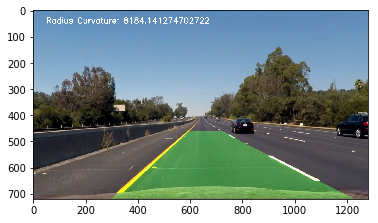

In [67]:
output_video = 'output_images/my_output.mp4'
clip = VideoFileClip("project_video.mp4")
res_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time res_clip.write_videofile(output_video, audio=False)

In [68]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))